In [11]:
import json, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import optuna

from loaders import DataLoader
from backtester import BackTester
from strategies.lgbm import StrategyLGBM

In [12]:
def featurise(data: pd.DataFrame, sampling: str):
    '''
        method to add additional features to the dataset
    '''
    # add log returns for the Close prices
    data['ln_Close'] = np.log(data['Close'] / data['Close'].shift(1))

    # simple ratios/diffs
    data[f'shadow_up_{sampling}'] = data['High'] - np.maximum(data['Close'], data['Open'])
    data[f'shadow_down_{sampling}'] = np.minimum(data['Close'], data['Open']) - data['Low']
    data[f"hl_ratio_{sampling}"] = data['High'] / data['Low']
    data[f"oc_diff_{sampling}"] = data['Open'] - data['Close']

    # Moving averages - 20, 50, 100, 200 observations
    data[f'MA20_{sampling}'] = data['Close'].rolling(window=20).mean()
    data[f'MA50_{sampling}'] = data['Close'].rolling(window=50).mean()
    data[f'MA100_{sampling}'] = data['Close'].rolling(window=100).mean()
    data[f'MA200_{sampling}'] = data['Close'].rolling(window=200).mean()
    data[f'MA200-MA100_{sampling}'] = data[f'MA200_{sampling}'] - data[f'MA100_{sampling}']
    data[f'MA200-MA50_{sampling}'] = data[f'MA200_{sampling}'] - data[f'MA50_{sampling}']
    data[f'MA200-MA20_{sampling}'] = data[f'MA200_{sampling}'] - data[f'MA20_{sampling}']
    data[f'MA100-MA50_{sampling}'] = data[f'MA100_{sampling}'] - data[f'MA50_{sampling}']
    data[f'MA100-MA20_{sampling}'] = data[f'MA100_{sampling}'] - data[f'MA20_{sampling}']
    data[f'MA50-MA20_{sampling}'] = data[f'MA50_{sampling}'] - data[f'MA20_{sampling}']

    # Exponential weighted moving averages - 8, 20 observations
    data[f'EWMA8_{sampling}'] = data['Close'].ewm(span=8, min_periods=8, adjust=False).mean()
    data[f'EWMA20_{sampling}'] = data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
    # Moving average convergence/divergence
    data[f'MACD_{sampling}'] = data[f'EWMA20_{sampling}'] - data[f'EWMA8_{sampling}']

    # Bollinger Bands - 20 observations, 2 std dev
    data['MA20_std'] = data['Close'].rolling(window=20).std()
    data[f'BB_high_{sampling}'] = data[f'MA20_{sampling}'] + 2 * data['MA20_std']
    data[f'BB_low_{sampling}'] = data[f'MA20_{sampling}'] - 2 * data['MA20_std']
    data[f'BB_highlow_{sampling}'] = data[f'BB_high_{sampling}'] / data[f'BB_low_{sampling}']
    data[f'BB_high_dist_{sampling}'] = data[f'BB_high_{sampling}'] - data['Close']
    data[f'BB_low_dist_{sampling}'] = data['Close'] - data[f'BB_low_{sampling}']
    data.drop(['MA20_std'], axis=1, inplace=True)

    # RSI
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=14, min_periods=14, adjust=False).mean()
    ema_down = down.ewm(com=14, min_periods=14, adjust=False).mean()
    rs = ema_up / ema_down
    data[f'RSI_{sampling}'] = 100 - (100 / (1 + rs))
    del delta, up, down, ema_up, ema_down, rs

    # realised volatility - 8, 20 observations (https://www.realvol.com/VolFormula.htm)
    samples_in_session = {'1H': 7, '3H': 3, '1D': 1, '1W': 0.2}
    rvol = lambda x: np.sqrt(np.sum(x ** 2) * 252 / (len(x) // samples_in_session[sampling])) * 100
    data[f'VOL8_{sampling}'] = data['ln_Close'].rolling(8).apply(rvol)
    data[f'VOL20_{sampling}'] = data['ln_Close'].rolling(20).apply(rvol)

    data.dropna(inplace=True)

    return data

def _resample(data: pd.DataFrame, sampling):
    data.set_index('Date', inplace=True)
    data = data.resample(sampling).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'})
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    return data

In [236]:
df = DataLoader.load('ibm', sampling='1H', year_start=2000)
# df = DataLoader.load('ibm', sampling='3H')

# with open('df_1d.pkl', 'rb') as f:
#     df_1d = pickle.load(f)

In [181]:
# res = []
# for dt in tqdm(df[df['Date'].dt.year >= 2000]['Date']):
# #     print(dt)
#     df0 = _resample(df[df['Date'] <= dt], '1D')
#     df0 = featurise(df0.iloc[-250:, :], '1D')
#     res.append(df0.iloc[-1].to_dict())
# df_1d = pd.DataFrame(res)

In [128]:
with open('ibm_extended.pkl', 'rb') as f:
    df = pickle.load(f)
    
df_train = df[df['Date'] <= '2016-08-04 15:00:00']
df_test = df[df['Date'] > '2016-08-04 15:00:00']

In [130]:
window = 3*252*4
df_test = pd.concat([df_train.iloc[-window:, :], df_test])

In [142]:
with open('lgbm_param_extended.json', 'r') as f:
    best_params = json.load(f)
best_params.update({
    "objective": "binary",
    "metric": "binary_error",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "seed": 42})
best_params

{'lambda_l1': 3.2103721382738583e-07,
 'lambda_l2': 0.004061512423464424,
 'num_leaves': 369,
 'feature_fraction': 0.9635235100821727,
 'bagging_fraction': 0.5900296966985026,
 'bagging_freq': 15,
 'min_child_samples': 44,
 'objective': 'binary',
 'metric': 'binary_error',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'seed': 42}

In [67]:
# with open('lgbm_optuna_study.pkl', 'rb') as f:
#     study = pickle.load(f)

In [14]:
# optuna.visualization.plot_param_importances(study)

In [146]:
strategy = StrategyLGBM(best_params)

backtester = BackTester(data=df_test,
                        strategy=strategy,
                        window=3*252*4,
                        refit_window=95)

backtester.run()

  0%|                                                                                                        | 0/4058 [00:00<?, ?it/s][I 2022-06-01 19:09:47,407] A new study created in memory with name: no-name-c7eed698-dd26-44c4-b4f3-485a26848c89

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:01<00:07,  1.23s/it][I 2022-06-01 19:09:48,642] Trial 0 finished with value: 0.5 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5.

feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:01<00:07,  1.23s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.500000:  29%|#################1                                          | 2/7 [00:03<00:07,  1.57s/it][I 2022-06-01 19:09:50,449] Trial 1 finished with value: 0.5 and parameters:

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:02<00:25,  1.39s/it][I 2022-06-01 19:10:00,873] Trial 8 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 74}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:02<00:25,  1.39s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  15%|#########7                                                       | 3/20 [00:04<00:23,  1.40s/it][I 2022-06-01 19:10:02,279] Trial 9 finished with valu


num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:13<00:09,  1.02s/it][I 2022-06-01 19:10:12,002] Trial 17 finished with value: 0.45 and parameters: {'num_leaves': 6}. Best is trial 15 with value: 0.45.

num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:13<00:09,  1.02s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000:  60%|######################################4                         | 12/20 [00:14<00:06,  1.19it/s][I 2022-06-01 19:10:12,421] Trial 18 finished with value: 0.48333333333333334 an

num_leaves, val_score: 0.450000:  95%|############################################################8   | 19/20 [00:22<00:01,  1.20s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000: 100%|################################################################| 20/20 [00:24<00:00,  1.22s/it]

bagging, val_score: 0.450000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'l

bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:03<00:01,  1.89it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:04<00:01,  1.90it/s][I 2022-06-01 19:10:26,655] Trial 34 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.7601376715831205, 'bagging_freq': 4}. Best is trial 28 with value: 0.45.

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:04<00:01,  1.90it/s]C:\Users\Yaroslav\Documen


feature_fraction_stage2, val_score: 0.450000: 100%|#####################################################| 6/6 [00:03<00:00,  1.98it/s]

regularization_factors, val_score: 0.450000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:   5%|##6                                                  | 1/20 [00:00<00:09,  2.00it/s][I 2022-06-01 19:10:31,251] Trial 43 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 1.164022785055525e-05, 'lambda_l2': 1.3463955201544065e-07}. Best is trial 43 with value: 0.4666666666666


regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:04<00:06,  1.94it/s][I 2022-06-01 19:10:34,834] Trial 50 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.36000510444014006, 'lambda_l2': 1.2716089285571946e-05}. Best is trial 45 with value: 0.45.

regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:04<00:06,  1.94it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  45%|#######################8                             | 9/20 [00:04<00:05,  1.96it/s][I 2022-06-0

regularization_factors, val_score: 0.450000:  80%|#########################################6          | 16/20 [00:08<00:02,  1.82it/s][I 2022-06-01 19:10:39,107] Trial 58 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 8.562894601671178e-06, 'lambda_l2': 0.00045308193206436344}. Best is trial 45 with value: 0.45.

regularization_factors, val_score: 0.450000:  80%|#########################################6          | 16/20 [00:08<00:02,  1.82it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  85%|############################################1       | 17/20 [00:08<00:01,  1.79it/s][I 2022-06-

min_data_in_leaf, val_score: 0.433333:  80%|################################################            | 4/5 [00:02<00:00,  1.72it/s][I 2022-06-01 19:10:43,811] Trial 66 finished with value: 0.43333333333333335 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.43333333333333335.

min_data_in_leaf, val_score: 0.433333:  80%|################################################            | 4/5 [00:02<00:00,  1.72it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

  0%|                                                                                             | 1/4058 [00:56<64:12:31, 56.98s/it][I 2022-06-01 19:10:44,482] A new study cre

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:01<00:09,  1.67s/it][I 2022-06-01 19:10:46,155] Trial 0 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.4166666666666667.

feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:01<00:09,  1.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.416667:  29%|#################1                                          | 2/7 [00:03<00:08,  1.72s/it][I 2022-06-01 19:10:47,908] Trial 1 finished w

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:02<00:25,  1.39s/it][I 2022-06-01 19:11:01,209] Trial 8 finished with value: 0.4 and parameters: {'num_leaves': 221}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:02<00:25,  1.39s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  15%|#########7                                                       | 3/20 [00:04<00:23,  1.37s/it][I 2022-06-01 19:11:02,561] Trial 9 finished with value: 0.4 and parameters: {'num_


num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:14<00:09,  1.08s/it][I 2022-06-01 19:11:12,692] Trial 17 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:14<00:09,  1.08s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  60%|######################################4                         | 12/20 [00:15<00:09,  1.16s/it][I 2022-06-01 19:11:14,019] Trial 18 finished with value: 0.4 and pa


num_leaves, val_score: 0.400000: 100%|################################################################| 20/20 [00:30<00:00,  1.52s/it]

bagging, val_score: 0.400000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  10%|######8                                                             | 1/10 [00:03<00:31,  3.54s/it][I 2022-06-01 19:11:32,379] Trial 27 finished with value: 0.55 and parameters: {'bagging_fraction': 0.9013689150823954, 'bagging_freq': 5}. Best is trial 27 with value: 0.55.

bagging, val_score: 0.400000:  10%|#


bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:23<00:05,  2.84s/it][I 2022-06-01 19:11:52,048] Trial 34 finished with value: 0.43333333333333335 and parameters: {'bagging_fraction': 0.4308387885916673, 'bagging_freq': 1}. Best is trial 30 with value: 0.43333333333333335.

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:23<00:05,  2.84s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  90%|#############################################################2      | 9/10 [00:27<00:03,  3.30s/it][I 2022-


regularization_factors, val_score: 0.400000:  15%|#######9                                             | 3/20 [00:08<00:47,  2.78s/it][I 2022-06-01 19:12:18,704] Trial 42 finished with value: 0.4 and parameters: {'lambda_l1': 3.896636461959348e-05, 'lambda_l2': 0.044271285143811144}. Best is trial 42 with value: 0.4.

regularization_factors, val_score: 0.400000:  15%|#######9                                             | 3/20 [00:08<00:47,  2.78s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  20%|##########6                                          | 4/20 [00:10<00:42,  2.65s/it][I 2022-06-01 19:12:21,149] 

regularization_factors, val_score: 0.400000:  55%|############################6                       | 11/20 [00:28<00:21,  2.43s/it][I 2022-06-01 19:12:38,816] Trial 50 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 0.03612327831889327, 'lambda_l2': 2.6368975071329954}. Best is trial 42 with value: 0.4.

regularization_factors, val_score: 0.400000:  55%|############################6                       | 11/20 [00:28<00:21,  2.43s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  60%|###############################2                    | 12/20 [00:29<00:16,  2.10s/it][I 2022-06-01 19:


regularization_factors, val_score: 0.400000:  95%|#################################################4  | 19/20 [00:44<00:02,  2.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000: 100%|####################################################| 20/20 [00:46<00:00,  2.33s/it]

min_data_in_leaf, val_score: 0.400000:   0%|                                                                    | 0/5 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass '

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.46s/it][I 2022-06-01 19:13:09,587] Trial 0 finished with value: 0.5 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.5.

feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.46s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:05<00:12,  2.59s/it][I 2022-06-01 19:13:12,270] Trial 1 finished with value: 0.4666666666666667 


num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:03<00:27,  1.54s/it][I 2022-06-01 19:13:27,267] Trial 8 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 8}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:03<00:27,  1.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  15%|#########7                                                       | 3/20 [00:05<00:32,  1.90s/it][I 2022-06-01 19:13:29,592] Trial 9 finished with valu


num_leaves, val_score: 0.466667:  50%|################################                                | 10/20 [00:21<00:21,  2.20s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:23<00:19,  2.20s/it][I 2022-06-01 19:13:47,332] Trial 17 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:23<00:19,  2.20s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:40<00:02,  2.14s/it][I 2022-06-01 19:14:04,595] Trial 25 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 157}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:40<00:02,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667: 100%|################################################################| 20/20 [00:43<00:00,  2.15s/it]

bagging, val_score: 0.466667:   0%|              


bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.18s/it][I 2022-06-01 19:14:30,414] Trial 33 finished with value: 0.5833333333333334 and parameters: {'bagging_fraction': 0.7040027083679046, 'bagging_freq': 5}. Best is trial 29 with value: 0.45.

bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.18s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:25<00:05,  2.88s/it][I 2022-06-01 19:14:32,6

feature_fraction_stage2, val_score: 0.450000:  83%|############################################1        | 5/6 [00:10<00:02,  2.14s/it][I 2022-06-01 19:14:49,611] Trial 41 finished with value: 0.45 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 40 with value: 0.45.

feature_fraction_stage2, val_score: 0.450000:  83%|############################################1        | 5/6 [00:10<00:02,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.450000: 100%|#####################################################| 6/6 [00:12<00:00,  2.14s/it]

regularization_factors, val_score: 0.450000:   0%|      


regularization_factors, val_score: 0.450000:  35%|##################5                                  | 7/20 [00:12<00:21,  1.65s/it][I 2022-06-01 19:15:04,279] Trial 49 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 9.234143174497127, 'lambda_l2': 0.00051443329560152}. Best is trial 46 with value: 0.4666666666666667.

regularization_factors, val_score: 0.450000:  35%|##################5                                  | 7/20 [00:12<00:21,  1.65s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:14<00:21,  1.78s/it][I 

regularization_factors, val_score: 0.433333:  75%|#######################################             | 15/20 [00:27<00:09,  1.92s/it][I 2022-06-01 19:15:19,468] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 0.17280592682046475, 'lambda_l2': 2.1223903316215892e-08}. Best is trial 53 with value: 0.43333333333333335.

regularization_factors, val_score: 0.433333:  75%|#######################################             | 15/20 [00:27<00:09,  1.92s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  80%|#########################################6          | 16/20 [00:29<00:07,  1.95s/it][I 2022-06-01


min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:06<00:04,  2.01s/it][I 2022-06-01 19:15:35,379] Trial 65 finished with value: 0.4166666666666667 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.4166666666666667.

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:06<00:04,  2.01s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.416667:  80%|################################################            | 4/5 [00:07<00:01,  1.99s/it][I 2022-06-01 19:15:37,327] Trial 66 finished

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.600000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.58s/it][I 2022-06-01 19:15:41,988] Trial 0 finished with value: 0.6 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.6.

feature_fraction, val_score: 0.600000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.58s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.533333:  29%|#################1                                          | 2/7 [00:05<00:13,  2.67s/it][I 2022-06-01 19:15:44,727] Trial 1 finished with value: 0.53

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:03<00:35,  1.95s/it][I 2022-06-01 19:15:58,772] Trial 8 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 100}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:03<00:35,  1.95s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  15%|#########7                                                       | 3/20 [00:05<00:33,  1.95s/it][I 2022-06-01 19:16:00,724] Trial 9 finished with val


num_leaves, val_score: 0.516667:  50%|################################                                | 10/20 [00:18<00:18,  1.88s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:20<00:16,  1.89s/it][I 2022-06-01 19:16:15,160] Trial 17 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 191}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:20<00:16,  1.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.516667:  95%|############################################################8   | 19/20 [00:34<00:01,  1.55s/it][I 2022-06-01 19:16:29,427] Trial 25 finished with value: 0.6 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  95%|############################################################8   | 19/20 [00:34<00:01,  1.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667: 100%|################################################################| 20/20 [00:36<00:00,  1.83s/it]

bagging, val_score: 0.516667:   0%|                               

bagging, val_score: 0.466667:  70%|###############################################5                    | 7/10 [00:19<00:08,  2.71s/it][I 2022-06-01 19:16:50,625] Trial 33 finished with value: 0.5833333333333334 and parameters: {'bagging_fraction': 0.9269698418781438, 'bagging_freq': 3}. Best is trial 32 with value: 0.4666666666666667.

bagging, val_score: 0.466667:  70%|###############################################5                    | 7/10 [00:19<00:08,  2.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.466667:  80%|######################################################4             | 8/10 [00:22<00:05,  2.79s/it][I 2022-06-


feature_fraction_stage2, val_score: 0.466667:  83%|############################################1        | 5/6 [00:08<00:01,  1.62s/it][I 2022-06-01 19:17:06,206] Trial 41 finished with value: 0.5666666666666667 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.5333333333333333.

feature_fraction_stage2, val_score: 0.466667:  83%|############################################1        | 5/6 [00:08<00:01,  1.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.466667: 100%|#####################################################| 6/6 [00:09<00:00,  1.63s/it]

regularization_factors, val


regularization_factors, val_score: 0.466667:  35%|##################5                                  | 7/20 [00:10<00:19,  1.49s/it][I 2022-06-01 19:17:18,777] Trial 49 finished with value: 0.6166666666666667 and parameters: {'lambda_l1': 2.4508168472868563, 'lambda_l2': 0.5061539555669016}. Best is trial 43 with value: 0.5.

regularization_factors, val_score: 0.466667:  35%|##################5                                  | 7/20 [00:10<00:19,  1.49s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  40%|#####################2                               | 8/20 [00:12<00:18,  1.53s/it][I 2022-06-01 19:1

regularization_factors, val_score: 0.466667:  75%|#######################################             | 15/20 [00:23<00:08,  1.62s/it][I 2022-06-01 19:17:31,636] Trial 57 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 9.948648426728674e-05, 'lambda_l2': 1.0953573906643021e-08}. Best is trial 56 with value: 0.48333333333333334.

regularization_factors, val_score: 0.466667:  75%|#######################################             | 15/20 [00:23<00:08,  1.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  80%|#########################################6          | 16/20 [00:25<00:06,  1.63


min_data_in_leaf, val_score: 0.466667:  60%|####################################                        | 3/5 [00:04<00:03,  1.61s/it][I 2022-06-01 19:17:44,683] Trial 65 finished with value: 0.4666666666666667 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.4666666666666667.

min_data_in_leaf, val_score: 0.466667:  60%|####################################                        | 3/5 [00:04<00:03,  1.61s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.466667:  80%|################################################            | 4/5 [00:06<00:01,  1.61s/it][I 2022-06-01 19:17:46,294] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:01<00:11,  1.91s/it][I 2022-06-01 19:17:49,976] Trial 0 finished with value: 0.5 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5.

feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:01<00:11,  1.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.500000:  29%|#################1                                          | 2/7 [00:04<00:11,  2.23s/it][I 2022-06-01 19:17:52,429] Trial 1 finished with value: 0.5166666666666667 

num_leaves, val_score: 0.500000:  10%|######5                                                          | 2/20 [00:03<00:31,  1.76s/it][I 2022-06-01 19:18:07,592] Trial 8 finished with value: 0.5 and parameters: {'num_leaves': 249}. Best is trial 7 with value: 0.5.

num_leaves, val_score: 0.500000:  10%|######5                                                          | 2/20 [00:03<00:31,  1.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000:  15%|#########7                                                       | 3/20 [00:04<00:25,  1.49s/it][I 2022-06-01 19:18:08,756] Trial 9 finished with value: 0.45 and parameters: {'num


num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:20<00:16,  1.87s/it][I 2022-06-01 19:18:24,532] Trial 17 finished with value: 0.5 and parameters: {'num_leaves': 52}. Best is trial 9 with value: 0.45.

num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:20<00:16,  1.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000:  60%|######################################4                         | 12/20 [00:20<00:11,  1.39s/it][I 2022-06-01 19:18:24,811] Trial 18 finished with value: 0.5 and parameters: {'n


num_leaves, val_score: 0.450000: 100%|################################################################| 20/20 [00:33<00:00,  1.69s/it]

bagging, val_score: 0.450000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  10%|######8                                                             | 1/10 [00:01<00:09,  1.01s/it][I 2022-06-01 19:18:38,968] Trial 27 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.7917872122559001, 'bagging_freq': 5}. Best is trial 27 with value: 0.5166666666666667.

bagging,


bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:08<00:02,  1.00s/it][I 2022-06-01 19:18:45,988] Trial 34 finished with value: 0.4666666666666667 and parameters: {'bagging_fraction': 0.7807871518385201, 'bagging_freq': 7}. Best is trial 34 with value: 0.4666666666666667.

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:08<00:02,  1.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  90%|#############################################################2      | 9/10 [00:09<00:00,  1.00it/s][I 2022-06


feature_fraction_stage2, val_score: 0.450000: 100%|#####################################################| 6/6 [00:06<00:00,  1.00s/it]

regularization_factors, val_score: 0.450000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:   5%|##6                                                  | 1/20 [00:00<00:18,  1.01it/s][I 2022-06-01 19:18:54,977] Trial 43 finished with value: 0.55 and parameters: {'lambda_l1': 8.602378120149894e-08, 'lambda_l2': 0.00012165401601254315}. Best is trial 43 with value: 0.55.

regularization_factors


regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:07<00:11,  1.02it/s][I 2022-06-01 19:19:01,880] Trial 50 finished with value: 0.5 and parameters: {'lambda_l1': 0.006765717649108701, 'lambda_l2': 0.004644312233016187}. Best is trial 48 with value: 0.4666666666666667.

regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:07<00:11,  1.02it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  45%|#######################8                             | 9/20 [00:08<00:10,  1.00it/s][I 2022-06-01 

regularization_factors, val_score: 0.450000:  80%|#########################################6          | 16/20 [00:15<00:04,  1.02s/it][I 2022-06-01 19:19:09,975] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 0.012058282825614594, 'lambda_l2': 0.0017639821484192158}. Best is trial 48 with value: 0.4666666666666667.

regularization_factors, val_score: 0.450000:  80%|#########################################6          | 16/20 [00:15<00:04,  1.02s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  85%|############################################1       | 17/20 [00:17<00:03,  1.03s/it][I 2022-06-01 


min_data_in_leaf, val_score: 0.450000:  80%|################################################            | 4/5 [00:03<00:00,  1.01it/s][I 2022-06-01 19:19:18,052] Trial 66 finished with value: 0.45 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.45.

min_data_in_leaf, val_score: 0.450000:  80%|################################################            | 4/5 [00:03<00:00,  1.01it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 11%|██████████▌                                                                                   | 458/4058 [09:31<51:33,  1.16it/s][I 2022-06-01 19:19:19,196] A new study created in memory with name: no-n

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.583333:  14%|########5                                                   | 1/7 [00:01<00:10,  1.76s/it][I 2022-06-01 19:19:20,967] Trial 0 finished with value: 0.5833333333333334 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.5833333333333334.

feature_fraction, val_score: 0.583333:  14%|########5                                                   | 1/7 [00:01<00:10,  1.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.566667:  29%|#################1                                          | 2/7 [00:04<00:10,  2.06s/it][I 2022-06-01 19:19:23,235] Trial 1 finished w

num_leaves, val_score: 0.550000:  10%|######5                                                          | 2/20 [00:03<00:32,  1.82s/it][I 2022-06-01 19:19:40,019] Trial 8 finished with value: 0.55 and parameters: {'num_leaves': 58}. Best is trial 7 with value: 0.55.

num_leaves, val_score: 0.550000:  10%|######5                                                          | 2/20 [00:03<00:32,  1.82s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.550000:  15%|#########7                                                       | 3/20 [00:05<00:31,  1.87s/it][I 2022-06-01 19:19:41,956] Trial 9 finished with value: 0.55 and parameters: {'nu


num_leaves, val_score: 0.550000:  55%|###################################2                            | 11/20 [00:20<00:15,  1.75s/it][I 2022-06-01 19:19:57,342] Trial 17 finished with value: 0.5833333333333334 and parameters: {'num_leaves': 17}. Best is trial 7 with value: 0.55.

num_leaves, val_score: 0.550000:  55%|###################################2                            | 11/20 [00:20<00:15,  1.75s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.550000:  60%|######################################4                         | 12/20 [00:22<00:14,  1.80s/it][I 2022-06-01 19:19:59,270] Trial 18 finished with value: 0.55 and


num_leaves, val_score: 0.550000: 100%|################################################################| 20/20 [00:37<00:00,  1.89s/it]

bagging, val_score: 0.550000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.550000:  10%|######8                                                             | 1/10 [00:03<00:29,  3.27s/it][I 2022-06-01 19:20:17,547] Trial 27 finished with value: 0.6 and parameters: {'bagging_fraction': 0.9903350999873732, 'bagging_freq': 6}. Best is trial 27 with value: 0.6.

bagging, val_score: 0.550000:  10%|###


bagging, val_score: 0.550000:  80%|######################################################4             | 8/10 [00:19<00:04,  2.38s/it][I 2022-06-01 19:20:34,046] Trial 34 finished with value: 0.6 and parameters: {'bagging_fraction': 0.6932865089556453, 'bagging_freq': 6}. Best is trial 33 with value: 0.55.

bagging, val_score: 0.550000:  80%|######################################################4             | 8/10 [00:19<00:04,  2.38s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.550000:  90%|#############################################################2      | 9/10 [00:22<00:02,  2.41s/it][I 2022-06-01 19:20:36,506] Trial 35 fi

feature_fraction_stage2, val_score: 0.550000: 100%|#####################################################| 6/6 [00:12<00:00,  2.03s/it]

regularization_factors, val_score: 0.550000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.550000:   5%|##6                                                  | 1/20 [00:02<00:38,  2.01s/it][I 2022-06-01 19:20:52,770] Trial 43 finished with value: 0.5666666666666667 and parameters: {'lambda_l1': 1.8127560619651678e-06, 'lambda_l2': 0.001958269486296761}. Best is trial 43 with value: 0.566666666666666


regularization_factors, val_score: 0.550000:  40%|#####################2                               | 8/20 [00:15<00:22,  1.87s/it][I 2022-06-01 19:21:06,007] Trial 50 finished with value: 0.5833333333333334 and parameters: {'lambda_l1': 0.002722025978996666, 'lambda_l2': 2.4639777824264426}. Best is trial 43 with value: 0.5666666666666667.

regularization_factors, val_score: 0.550000:  40%|#####################2                               | 8/20 [00:15<00:22,  1.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.550000:  45%|#######################8                             | 9/20 [00:17<00:20,  1.83s/it][

regularization_factors, val_score: 0.550000:  80%|#########################################6          | 16/20 [00:30<00:08,  2.04s/it][I 2022-06-01 19:21:21,660] Trial 58 finished with value: 0.5833333333333334 and parameters: {'lambda_l1': 4.053665080709251e-07, 'lambda_l2': 0.08192275340775512}. Best is trial 56 with value: 0.55.

regularization_factors, val_score: 0.550000:  80%|#########################################6          | 16/20 [00:30<00:08,  2.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.550000:  85%|############################################1       | 17/20 [00:33<00:06,  2.06s/it][I 2022-06-01 

min_data_in_leaf, val_score: 0.550000:  80%|################################################            | 4/5 [00:08<00:02,  2.07s/it][I 2022-06-01 19:21:38,245] Trial 66 finished with value: 0.55 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.55.

min_data_in_leaf, val_score: 0.550000:  80%|################################################            | 4/5 [00:08<00:02,  2.07s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 14%|████████████▋                                                                                 | 550/4058 [11:52<58:33,  1.00s/it][I 2022-06-01 19:21:40,277] A new study created in memory with name: no-

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.566667:  14%|########5                                                   | 1/7 [00:02<00:16,  2.80s/it][I 2022-06-01 19:21:43,081] Trial 0 finished with value: 0.5666666666666667 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.5666666666666667.

feature_fraction, val_score: 0.566667:  14%|########5                                                   | 1/7 [00:02<00:16,  2.80s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.566667:  29%|#################1                                          | 2/7 [00:05<00:12,  2.55s/it][I 2022-06-01 19:21:45,463] Trial 1 finished w

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:03<00:29,  1.63s/it][I 2022-06-01 19:21:59,253] Trial 8 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 66}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:03<00:29,  1.63s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  15%|#########7                                                       | 3/20 [00:04<00:28,  1.65s/it][I 2022-06-01 19:22:00,939] Trial 9 finished with valu


num_leaves, val_score: 0.516667:  50%|################################                                | 10/20 [00:16<00:16,  1.60s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:17<00:13,  1.49s/it][I 2022-06-01 19:22:13,354] Trial 17 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 19}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:17<00:13,  1.49s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.516667:  95%|############################################################8   | 19/20 [00:30<00:01,  1.66s/it][I 2022-06-01 19:22:26,682] Trial 25 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 195}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  95%|############################################################8   | 19/20 [00:30<00:01,  1.66s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667: 100%|################################################################| 20/20 [00:30<00:00,  1.55s/it]

bagging, val_score: 0.516667:   0%|              


bagging, val_score: 0.483333:  70%|###############################################5                    | 7/10 [00:13<00:06,  2.11s/it][I 2022-06-01 19:22:40,657] Trial 33 finished with value: 0.5666666666666667 and parameters: {'bagging_fraction': 0.9553374033944286, 'bagging_freq': 7}. Best is trial 32 with value: 0.48333333333333334.

bagging, val_score: 0.483333:  70%|###############################################5                    | 7/10 [00:13<00:06,  2.11s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.483333:  80%|######################################################4             | 8/10 [00:15<00:03,  1.99s/it][I 2022-0


regularization_factors, val_score: 0.483333:  10%|#####3                                               | 2/20 [00:03<00:35,  1.95s/it][I 2022-06-01 19:22:56,574] Trial 41 finished with value: 0.55 and parameters: {'lambda_l1': 1.743718175601316e-08, 'lambda_l2': 1.051501561578034}. Best is trial 40 with value: 0.5.

regularization_factors, val_score: 0.483333:  10%|#####3                                               | 2/20 [00:03<00:35,  1.95s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.483333:  15%|#######9                                             | 3/20 [00:05<00:34,  2.01s/it][I 2022-06-01 19:22:58,661] Tr

regularization_factors, val_score: 0.466667:  50%|##########################                          | 10/20 [00:18<00:19,  1.92s/it][I 2022-06-01 19:23:11,402] Trial 49 finished with value: 0.5333333333333333 and parameters: {'lambda_l1': 9.887360354555415e-05, 'lambda_l2': 0.0011208981272463748}. Best is trial 47 with value: 0.4666666666666667.

regularization_factors, val_score: 0.466667:  50%|##########################                          | 10/20 [00:18<00:19,  1.92s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  55%|############################6                       | 11/20 [00:21<00:20,  2.31s/i

regularization_factors, val_score: 0.466667:  90%|##############################################8     | 18/20 [00:36<00:04,  2.12s/it][I 2022-06-01 19:23:29,543] Trial 57 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 0.27593464385598393, 'lambda_l2': 1.059266520520534e-06}. Best is trial 47 with value: 0.4666666666666667.

regularization_factors, val_score: 0.466667:  90%|##############################################8     | 18/20 [00:36<00:04,  2.12s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  95%|#################################################4  | 19/20 [00:39<00:02,  2.17s/it]

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it][I 2022-06-01 19:23:43,919] Trial 0 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4666666666666667.

feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:05<00:13,  2.62s/it][I 2022-06-01 19:23:46,708] Trial 1 finished w

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:02<00:25,  1.40s/it][I 2022-06-01 19:24:00,000] Trial 8 finished with value: 0.4 and parameters: {'num_leaves': 71}. Best is trial 8 with value: 0.4.

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:02<00:25,  1.40s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  15%|#########7                                                       | 3/20 [00:04<00:25,  1.53s/it][I 2022-06-01 19:24:01,681] Trial 9 finished with value: 0.4 and parameters: {'num_l


num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:17<00:14,  1.64s/it][I 2022-06-01 19:24:14,548] Trial 17 finished with value: 0.4 and parameters: {'num_leaves': 71}. Best is trial 8 with value: 0.4.

num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:17<00:14,  1.64s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  60%|######################################4                         | 12/20 [00:18<00:13,  1.65s/it][I 2022-06-01 19:24:16,222] Trial 18 finished with value: 0.4 and parameters: {'nu


num_leaves, val_score: 0.400000: 100%|################################################################| 20/20 [00:32<00:00,  1.61s/it]

bagging, val_score: 0.400000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  10%|######8                                                             | 1/10 [00:02<00:18,  2.02s/it][I 2022-06-01 19:24:31,541] Trial 27 finished with value: 0.45 and parameters: {'bagging_fraction': 0.6930297716565721, 'bagging_freq': 5}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.400000:  10%|#


bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:16<00:04,  2.16s/it][I 2022-06-01 19:24:45,790] Trial 34 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.897449927362878, 'bagging_freq': 1}. Best is trial 28 with value: 0.4166666666666667.

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:16<00:04,  2.16s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  90%|#############################################################2      | 9/10 [00:18<00:02,  2.09s/it][I 2022-06-


regularization_factors, val_score: 0.400000:  15%|#######9                                             | 3/20 [00:05<00:31,  1.85s/it][I 2022-06-01 19:25:00,545] Trial 42 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 2.9044094904641576e-08, 'lambda_l2': 2.698368175769417e-08}. Best is trial 41 with value: 0.4.

regularization_factors, val_score: 0.400000:  15%|#######9                                             | 3/20 [00:05<00:31,  1.85s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  20%|##########6                                          | 4/20 [00:07<00:28,  1.81s/it][I 2022-06

regularization_factors, val_score: 0.400000:  55%|############################6                       | 11/20 [00:18<00:15,  1.71s/it][I 2022-06-01 19:25:14,050] Trial 50 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 4.833703892344608e-07, 'lambda_l2': 0.0006465309563825562}. Best is trial 41 with value: 0.4.

regularization_factors, val_score: 0.400000:  55%|############################6                       | 11/20 [00:18<00:15,  1.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  60%|###############################2                    | 12/20 [00:19<00:11,  1.47s/it][I 2022-06-01


regularization_factors, val_score: 0.400000:  95%|#################################################4  | 19/20 [00:32<00:01,  1.74s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000: 100%|####################################################| 20/20 [00:33<00:00,  1.68s/it]

min_data_in_leaf, val_score: 0.400000:   0%|                                                                    | 0/5 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass '

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.383333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.76s/it][I 2022-06-01 19:25:40,240] Trial 0 finished with value: 0.38333333333333336 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.38333333333333336.

feature_fraction, val_score: 0.383333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.383333:  29%|#################1                                          | 2/7 [00:04<00:11,  2.33s/it][I 2022-06-01 19:25:42,277] Trial 1 finished

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:04<00:38,  2.15s/it][I 2022-06-01 19:25:57,348] Trial 8 finished with value: 0.35 and parameters: {'num_leaves': 227}. Best is trial 8 with value: 0.35.

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:04<00:38,  2.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  15%|#########7                                                       | 3/20 [00:06<00:38,  2.27s/it][I 2022-06-01 19:25:59,760] Trial 9 finished with value: 0.35 and parameters: {'n


num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:25<00:21,  2.39s/it][I 2022-06-01 19:26:18,465] Trial 17 finished with value: 0.35 and parameters: {'num_leaves': 251}. Best is trial 8 with value: 0.35.

num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:25<00:21,  2.39s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  60%|######################################4                         | 12/20 [00:27<00:19,  2.39s/it][I 2022-06-01 19:26:20,859] Trial 18 finished with value: 0.35 and parameters: 


num_leaves, val_score: 0.350000: 100%|################################################################| 20/20 [00:47<00:00,  2.38s/it]

bagging, val_score: 0.350000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  10%|######8                                                             | 1/10 [00:02<00:20,  2.30s/it][I 2022-06-01 19:26:43,104] Trial 27 finished with value: 0.45 and parameters: {'bagging_fraction': 0.5153832640620044, 'bagging_freq': 2}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.350000:  10%|#


bagging, val_score: 0.316667:  80%|######################################################4             | 8/10 [00:21<00:05,  2.78s/it][I 2022-06-01 19:27:02,575] Trial 34 finished with value: 0.35 and parameters: {'bagging_fraction': 0.5175410708043343, 'bagging_freq': 4}. Best is trial 29 with value: 0.31666666666666665.

bagging, val_score: 0.316667:  80%|######################################################4             | 8/10 [00:21<00:05,  2.78s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.316667:  90%|#############################################################2      | 9/10 [00:23<00:02,  2.56s/it][I 2022-06-01 19:27:04,


feature_fraction_stage2, val_score: 0.316667: 100%|#####################################################| 6/6 [00:15<00:00,  2.51s/it]

regularization_factors, val_score: 0.316667:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.316667:   5%|##6                                                  | 1/20 [00:02<00:38,  2.02s/it][I 2022-06-01 19:27:25,427] Trial 43 finished with value: 0.45 and parameters: {'lambda_l1': 0.5253270727051388, 'lambda_l2': 5.906409653806877e-08}. Best is trial 43 with value: 0.45.

regularization_factors, va


regularization_factors, val_score: 0.316667:  40%|#####################2                               | 8/20 [00:19<00:30,  2.55s/it][I 2022-06-01 19:27:43,050] Trial 50 finished with value: 0.35 and parameters: {'lambda_l1': 0.0022849156039408173, 'lambda_l2': 3.1656250751599995e-05}. Best is trial 49 with value: 0.3333333333333333.

regularization_factors, val_score: 0.316667:  40%|#####################2                               | 8/20 [00:19<00:30,  2.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.316667:  45%|#######################8                             | 9/20 [00:22<00:27,  2.53s/it][I 2022-06

regularization_factors, val_score: 0.316667:  80%|#########################################6          | 16/20 [00:37<00:09,  2.32s/it][I 2022-06-01 19:28:01,347] Trial 58 finished with value: 0.38333333333333336 and parameters: {'lambda_l1': 1.0119686092665105e-08, 'lambda_l2': 1.1313269724921417e-08}. Best is trial 49 with value: 0.3333333333333333.

regularization_factors, val_score: 0.316667:  80%|#########################################6          | 16/20 [00:37<00:09,  2.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.316667:  85%|############################################1       | 17/20 [00:40<00:06,  2.32


min_data_in_leaf, val_score: 0.316667:  80%|################################################            | 4/5 [00:10<00:02,  2.66s/it][I 2022-06-01 19:28:21,365] Trial 66 finished with value: 0.31666666666666665 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.31666666666666665.

min_data_in_leaf, val_score: 0.316667:  80%|################################################            | 4/5 [00:10<00:02,  2.66s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 20%|██████████████████▋                                                                         | 826/4058 [18:36<1:04:23,  1.20s/it][I 2022-06-01 19:28:24,108] A new study cre

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:02<00:17,  2.94s/it][I 2022-06-01 19:28:27,060] Trial 0 finished with value: 0.5166666666666667 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5166666666666667.

feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:02<00:17,  2.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.483333:  29%|#################1                                          | 2/7 [00:05<00:12,  2.56s/it][I 2022-06-01 19:28:29,355] Trial 1 finished w

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:02<00:24,  1.37s/it][I 2022-06-01 19:28:44,739] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 11}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:02<00:24,  1.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:04<00:26,  1.57s/it][I 2022-06-01 19:28:46,558] Trial 9 finished with va

num_leaves, val_score: 0.416667:  50%|################################                                | 10/20 [00:16<00:15,  1.57s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:18<00:15,  1.68s/it][I 2022-06-01 19:29:00,091] Trial 17 finished with value: 0.45 and parameters: {'num_leaves': 236}. Best is trial 11 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:18<00:15,  1.68s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\s


num_leaves, val_score: 0.416667:  95%|############################################################8   | 19/20 [00:30<00:01,  1.64s/it][I 2022-06-01 19:29:12,122] Trial 25 finished with value: 0.45 and parameters: {'num_leaves': 103}. Best is trial 11 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  95%|############################################################8   | 19/20 [00:30<00:01,  1.64s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667: 100%|################################################################| 20/20 [00:31<00:00,  1.60s/it]

bagging, val_score: 0.416667:   0%|                           

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:12<00:05,  1.74s/it][I 2022-06-01 19:29:25,820] Trial 33 finished with value: 0.5333333333333333 and parameters: {'bagging_fraction': 0.6059208421347797, 'bagging_freq': 2}. Best is trial 29 with value: 0.45.

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:12<00:05,  1.74s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.416667:  80%|######################################################4             | 8/10 [00:13<00:03,  1.75s/it][I 2022-06-01 19:29:27,58


regularization_factors, val_score: 0.416667:  10%|#####3                                               | 2/20 [00:03<00:28,  1.56s/it][I 2022-06-01 19:29:39,018] Trial 41 finished with value: 0.45 and parameters: {'lambda_l1': 0.011153065576696439, 'lambda_l2': 6.899570335635579e-08}. Best is trial 41 with value: 0.45.

regularization_factors, val_score: 0.416667:  10%|#####3                                               | 2/20 [00:03<00:28,  1.56s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  15%|#######9                                             | 3/20 [00:04<00:26,  1.57s/it][I 2022-06-01 19:29:40,595

regularization_factors, val_score: 0.366667:  50%|##########################                          | 10/20 [00:15<00:15,  1.52s/it][I 2022-06-01 19:29:51,015] Trial 49 finished with value: 0.36666666666666664 and parameters: {'lambda_l1': 1.1349980636364266e-05, 'lambda_l2': 0.0035958162668826223}. Best is trial 49 with value: 0.36666666666666664.

regularization_factors, val_score: 0.366667:  50%|##########################                          | 10/20 [00:15<00:15,  1.52s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  55%|############################6                       | 11/20 [00:16<00:13,  1.49

regularization_factors, val_score: 0.366667:  90%|##############################################8     | 18/20 [00:26<00:03,  1.50s/it][I 2022-06-01 19:30:02,820] Trial 57 finished with value: 0.45 and parameters: {'lambda_l1': 0.16593122233460172, 'lambda_l2': 0.26589243678111113}. Best is trial 49 with value: 0.36666666666666664.

regularization_factors, val_score: 0.366667:  90%|##############################################8     | 18/20 [00:26<00:03,  1.50s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  95%|#################################################4  | 19/20 [00:28<00:01,  1.53s/it][I 2022-06-01 1

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.400000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it][I 2022-06-01 19:30:16,405] Trial 0 finished with value: 0.4 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4.

feature_fraction, val_score: 0.400000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.400000:  29%|#################1                                          | 2/7 [00:05<00:13,  2.60s/it][I 2022-06-01 19:30:19,178] Trial 1 finished with value: 0.43333333333333335

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:05<00:45,  2.55s/it][I 2022-06-01 19:30:35,651] Trial 8 finished with value: 0.4 and parameters: {'num_leaves': 219}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:05<00:45,  2.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  15%|#########7                                                       | 3/20 [00:07<00:43,  2.55s/it][I 2022-06-01 19:30:38,195] Trial 9 finished with value: 0.4 and parameters: {'num_


num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:25<00:20,  2.31s/it][I 2022-06-01 19:30:56,517] Trial 17 finished with value: 0.4 and parameters: {'num_leaves': 99}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:26<00:20,  2.31s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  60%|######################################4                         | 12/20 [00:28<00:19,  2.43s/it][I 2022-06-01 19:30:59,217] Trial 18 finished with value: 0.4 and parameters: {'nu


num_leaves, val_score: 0.400000: 100%|################################################################| 20/20 [00:50<00:00,  2.51s/it]

bagging, val_score: 0.400000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  10%|######8                                                             | 1/10 [00:04<00:37,  4.15s/it][I 2022-06-01 19:31:24,790] Trial 27 finished with value: 0.45 and parameters: {'bagging_fraction': 0.8463847358941126, 'bagging_freq': 2}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.400000:  10%|#


bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:26<00:06,  3.15s/it][I 2022-06-01 19:31:46,972] Trial 34 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.5742123081985776, 'bagging_freq': 6}. Best is trial 28 with value: 0.43333333333333335.

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:26<00:06,  3.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  90%|#############################################################2      | 9/10 [00:28<00:02,  2.78s/it][I 2022-0

feature_fraction_stage2, val_score: 0.400000: 100%|#####################################################| 6/6 [00:16<00:00,  2.72s/it]

regularization_factors, val_score: 0.400000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:   5%|##6                                                  | 1/20 [00:03<00:57,  3.01s/it][I 2022-06-01 19:32:12,319] Trial 43 finished with value: 0.5 and parameters: {'lambda_l1': 7.636001349969468e-05, 'lambda_l2': 6.620326819858615e-08}. Best is trial 43 with value: 0.5.

regularization_factors, va


regularization_factors, val_score: 0.400000:  40%|#####################2                               | 8/20 [00:20<00:31,  2.63s/it][I 2022-06-01 19:32:30,285] Trial 50 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 2.2688605429503033e-08, 'lambda_l2': 0.0007437714538725531}. Best is trial 44 with value: 0.43333333333333335.

regularization_factors, val_score: 0.400000:  40%|#####################2                               | 8/20 [00:20<00:31,  2.63s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  45%|#######################8                             | 9/20 [00:23<00:28,  2.57

regularization_factors, val_score: 0.400000:  80%|#########################################6          | 16/20 [00:38<00:08,  2.17s/it][I 2022-06-01 19:32:47,546] Trial 58 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 0.006914923051608341, 'lambda_l2': 1.474140555213273e-05}. Best is trial 51 with value: 0.4166666666666667.

regularization_factors, val_score: 0.400000:  80%|#########################################6          | 16/20 [00:38<00:08,  2.17s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  85%|############################################1       | 17/20 [00:40<00:06,  2.24s/i


min_data_in_leaf, val_score: 0.400000:  80%|################################################            | 4/5 [00:09<00:02,  2.41s/it][I 2022-06-01 19:33:06,712] Trial 66 finished with value: 0.4 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4.

min_data_in_leaf, val_score: 0.400000:  80%|################################################            | 4/5 [00:09<00:02,  2.41s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 25%|██████████████████████▋                                                                    | 1011/4058 [23:21<1:05:32,  1.29s/it][I 2022-06-01 19:33:09,431] A new study created in memory with name: no-na

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:03<00:20,  3.36s/it][I 2022-06-01 19:33:12,801] Trial 0 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.4666666666666667.

feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:03<00:20,  3.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:08<00:21,  4.27s/it][I 2022-06-01 19:33:17,710] Tri

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:03<00:30,  1.68s/it][I 2022-06-01 19:33:33,814] Trial 8 finished with value: 0.4 and parameters: {'num_leaves': 113}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:03<00:30,  1.68s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  15%|#########7                                                       | 3/20 [00:05<00:28,  1.67s/it][I 2022-06-01 19:33:35,466] Trial 9 finished with value: 0.4 and parameters: {'num_


num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:18<00:15,  1.71s/it][I 2022-06-01 19:33:48,836] Trial 17 finished with value: 0.4 and parameters: {'num_leaves': 213}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:18<00:15,  1.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  60%|######################################4                         | 12/20 [00:20<00:13,  1.72s/it][I 2022-06-01 19:33:50,558] Trial 18 finished with value: 0.4 and parameters: {'n


num_leaves, val_score: 0.400000: 100%|################################################################| 20/20 [00:33<00:00,  1.69s/it]

bagging, val_score: 0.400000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  10%|######8                                                             | 1/10 [00:02<00:24,  2.73s/it][I 2022-06-01 19:34:06,941] Trial 27 finished with value: 0.48333333333333334 and parameters: {'bagging_fraction': 0.9213571897411007, 'bagging_freq': 1}. Best is trial 27 with value: 0.48333333333333334.

baggin


bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:18<00:04,  2.43s/it][I 2022-06-01 19:34:22,988] Trial 34 finished with value: 0.45 and parameters: {'bagging_fraction': 0.9039838616272909, 'bagging_freq': 5}. Best is trial 31 with value: 0.45.

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:18<00:04,  2.43s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  90%|#############################################################2      | 9/10 [00:20<00:02,  2.10s/it][I 2022-06-01 19:34:24,363] Trial 35 f


regularization_factors, val_score: 0.350000:  15%|#######9                                             | 3/20 [00:05<00:31,  1.86s/it][I 2022-06-01 19:34:38,356] Trial 42 finished with value: 0.45 and parameters: {'lambda_l1': 0.0792142163788458, 'lambda_l2': 4.172391092199676}. Best is trial 41 with value: 0.4.

regularization_factors, val_score: 0.350000:  15%|#######9                                             | 3/20 [00:05<00:31,  1.86s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  20%|##########6                                          | 4/20 [00:07<00:30,  1.91s/it][I 2022-06-01 19:34:40,349] Trial

regularization_factors, val_score: 0.350000:  55%|############################6                       | 11/20 [00:20<00:16,  1.82s/it][I 2022-06-01 19:34:53,191] Trial 50 finished with value: 0.5 and parameters: {'lambda_l1': 2.6535271958173774e-08, 'lambda_l2': 4.287995763402938e-06}. Best is trial 48 with value: 0.38333333333333336.

regularization_factors, val_score: 0.350000:  55%|############################6                       | 11/20 [00:20<00:16,  1.82s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  60%|###############################2                    | 12/20 [00:21<00:12,  1.62s/it][I 2022-06-

regularization_factors, val_score: 0.350000:  95%|#################################################4  | 19/20 [00:32<00:01,  1.62s/it][I 2022-06-01 19:35:05,581] Trial 58 finished with value: 0.35 and parameters: {'lambda_l1': 1.0964295588177304, 'lambda_l2': 0.9611488414338624}. Best is trial 58 with value: 0.35.

regularization_factors, val_score: 0.350000:  95%|#################################################4  | 19/20 [00:32<00:01,  1.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000: 100%|####################################################| 20/20 [00:34<00:00,  1.72s/it]

min_data_in_leaf, val_score: 0

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.61s/it][I 2022-06-01 19:35:18,818] Trial 0 finished with value: 0.45 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.45.

feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.61s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:04<00:11,  2.30s/it][I 2022-06-01 19:35:20,904] Trial 1 finished with value: 0.

num_leaves, val_score: 0.416667:  10%|######5                                                          | 2/20 [00:05<00:49,  2.74s/it][I 2022-06-01 19:35:37,569] Trial 8 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 203}. Best is trial 7 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  10%|######5                                                          | 2/20 [00:05<00:49,  2.74s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667:  15%|#########7                                                       | 3/20 [00:08<00:46,  2.74s/it][I 2022-06-01 19:35:40,304] Trial 9 finished with val


num_leaves, val_score: 0.416667:  50%|################################                                | 10/20 [00:28<00:28,  2.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:29<00:20,  2.28s/it][I 2022-06-01 19:36:01,351] Trial 17 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:29<00:20,  2.28s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_serie


num_leaves, val_score: 0.416667:  95%|############################################################8   | 19/20 [00:51<00:02,  2.76s/it][I 2022-06-01 19:36:23,384] Trial 25 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 88}. Best is trial 7 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  95%|############################################################8   | 19/20 [00:51<00:02,  2.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667: 100%|################################################################| 20/20 [00:54<00:00,  2.71s/it]

bagging, val_score: 0.416667:   0%|               


bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:22<00:10,  3.54s/it][I 2022-06-01 19:36:49,220] Trial 33 finished with value: 0.4666666666666667 and parameters: {'bagging_fraction': 0.7841229644310208, 'bagging_freq': 4}. Best is trial 29 with value: 0.43333333333333335.

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:22<00:10,  3.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.416667:  80%|######################################################4             | 8/10 [00:26<00:07,  3.69s/it][I 2022-0


regularization_factors, val_score: 0.416667:  10%|#####3                                               | 2/20 [00:05<00:51,  2.85s/it][I 2022-06-01 19:37:16,831] Trial 41 finished with value: 0.45 and parameters: {'lambda_l1': 0.09177943096882524, 'lambda_l2': 0.9252725815223944}. Best is trial 41 with value: 0.45.

regularization_factors, val_score: 0.416667:  10%|#####3                                               | 2/20 [00:05<00:51,  2.85s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  15%|#######9                                             | 3/20 [00:07<00:39,  2.34s/it][I 2022-06-01 19:37:18,573] Tr

regularization_factors, val_score: 0.416667:  50%|##########################                          | 10/20 [00:24<00:24,  2.44s/it][I 2022-06-01 19:37:35,481] Trial 49 finished with value: 0.45 and parameters: {'lambda_l1': 0.15695769931713, 'lambda_l2': 0.022561002195768586}. Best is trial 42 with value: 0.43333333333333335.

regularization_factors, val_score: 0.416667:  50%|##########################                          | 10/20 [00:24<00:24,  2.44s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  55%|############################6                       | 11/20 [00:27<00:23,  2.61s/it][I 2022-06-01 19:

regularization_factors, val_score: 0.416667:  90%|##############################################8     | 18/20 [00:44<00:04,  2.47s/it][I 2022-06-01 19:37:55,238] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 1.358360148088608e-08, 'lambda_l2': 0.000693998564016524}. Best is trial 42 with value: 0.43333333333333335.

regularization_factors, val_score: 0.416667:  90%|##############################################8     | 18/20 [00:44<00:04,  2.47s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  95%|#################################################4  | 19/20 [00:46<00:02,  2.55s/i

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:15,  2.55s/it][I 2022-06-01 19:38:17,335] Trial 0 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.48333333333333334.

feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:15,  2.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:04<00:11,  2.26s/it][I 2022-06-01 19:38:19,391] T

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:02<00:27,  1.52s/it][I 2022-06-01 19:38:33,691] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 72}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:02<00:27,  1.52s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:04<00:27,  1.60s/it][I 2022-06-01 19:38:35,389] Trial 9 finished with va


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:17<00:17,  1.78s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:18<00:15,  1.77s/it][I 2022-06-01 19:38:49,513] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 64}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:18<00:15,  1.77s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_se


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:31<00:01,  1.49s/it][I 2022-06-01 19:39:01,763] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 200}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:31<00:01,  1.49s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:32<00:00,  1.64s/it]

bagging, val_score: 0.433333:   0%|            


bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.09s/it][I 2022-06-01 19:39:18,720] Trial 33 finished with value: 0.5 and parameters: {'bagging_fraction': 0.7894391563431782, 'bagging_freq': 5}. Best is trial 28 with value: 0.4666666666666667.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:17<00:04,  2.10s/it][I 2022-06-01 19:39:20,83


regularization_factors, val_score: 0.366667:  10%|#####3                                               | 2/20 [00:03<00:33,  1.89s/it][I 2022-06-01 19:39:37,095] Trial 41 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.07447700722502358, 'lambda_l2': 0.0002329266813626685}. Best is trial 41 with value: 0.4666666666666667.

regularization_factors, val_score: 0.366667:  10%|#####3                                               | 2/20 [00:03<00:33,  1.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  15%|#######9                                             | 3/20 [00:05<00:30,  1.81s/it

regularization_factors, val_score: 0.366667:  50%|##########################                          | 10/20 [00:19<00:18,  1.90s/it][I 2022-06-01 19:39:52,424] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 0.1444504160682566, 'lambda_l2': 8.02446305220099}. Best is trial 44 with value: 0.4.

regularization_factors, val_score: 0.366667:  50%|##########################                          | 10/20 [00:19<00:18,  1.90s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  55%|############################6                       | 11/20 [00:21<00:17,  1.97s/it][I 2022-06-01 19:39:54,558] Trial 50

regularization_factors, val_score: 0.366667:  90%|##############################################8     | 18/20 [00:33<00:03,  1.58s/it][I 2022-06-01 19:40:07,333] Trial 57 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 6.358717419637767, 'lambda_l2': 1.0093969203241306e-06}. Best is trial 44 with value: 0.4.

regularization_factors, val_score: 0.366667:  90%|##############################################8     | 18/20 [00:33<00:03,  1.58s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  95%|#################################################4  | 19/20 [00:36<00:01,  1.76s/it][I 2022-06-01 1

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.550000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.66s/it][I 2022-06-01 19:40:25,088] Trial 0 finished with value: 0.55 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.55.

feature_fraction, val_score: 0.550000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.66s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:04<00:12,  2.43s/it][I 2022-06-01 19:40:27,361] Trial 1 finished with value: 0.

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:04<00:38,  2.14s/it][I 2022-06-01 19:40:42,707] Trial 8 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 115}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:04<00:38,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  15%|#########7                                                       | 3/20 [00:06<00:36,  2.13s/it][I 2022-06-01 19:40:44,832] Trial 9 finished with val


num_leaves, val_score: 0.466667:  50%|################################                                | 10/20 [00:20<00:17,  1.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:22<00:16,  1.85s/it][I 2022-06-01 19:41:00,648] Trial 17 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:22<00:16,  1.85s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:38<00:01,  1.77s/it][I 2022-06-01 19:41:17,079] Trial 25 finished with value: 0.55 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:38<00:01,  1.77s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667: 100%|################################################################| 20/20 [00:40<00:00,  2.05s/it]

bagging, val_score: 0.466667:   0%|                              


bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:24<00:10,  3.48s/it][I 2022-06-01 19:41:43,496] Trial 33 finished with value: 0.5 and parameters: {'bagging_fraction': 0.8706903253738607, 'bagging_freq': 6}. Best is trial 28 with value: 0.4166666666666667.

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:24<00:10,  3.48s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.416667:  80%|######################################################4             | 8/10 [00:27<00:06,  3.47s/it][I 2022-06-01 19:41:46,93


feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:08<00:01,  1.66s/it][I 2022-06-01 19:42:01,190] Trial 41 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.716}. Best is trial 38 with value: 0.43333333333333335.

feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:08<00:01,  1.66s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.416667: 100%|#####################################################| 6/6 [00:10<00:00,  1.70s/it]

regularization_factors, val_score: 0.4


regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:11<00:20,  1.61s/it][I 2022-06-01 19:42:14,050] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 2.818555888465965e-05, 'lambda_l2': 8.891328647618729e-08}. Best is trial 43 with value: 0.48333333333333334.

regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:11<00:20,  1.61s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  40%|#####################2                               | 8/20 [00:12<00:19,  1.62s/it][I 2022-06-

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:22<00:06,  1.32s/it][I 2022-06-01 19:42:25,514] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 7.002321977771602, 'lambda_l2': 1.775310202082455e-05}. Best is trial 53 with value: 0.45.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:22<00:06,  1.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [00:24<00:05,  1.41s/it][I 2022-06-01 19

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:04<00:03,  1.59s/it][I 2022-06-01 19:42:38,139] Trial 65 finished with value: 0.4166666666666667 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4166666666666667.

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:04<00:03,  1.59s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.416667:  80%|################################################            | 4/5 [00:06<00:01,  1.60s/it][I 2022-06-01 19:42:39,744] Trial 66 finished

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.400000:  14%|########5                                                   | 1/7 [00:01<00:10,  1.79s/it][I 2022-06-01 19:42:43,248] Trial 0 finished with value: 0.4 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.4.

feature_fraction, val_score: 0.400000:  14%|########5                                                   | 1/7 [00:01<00:10,  1.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.400000:  29%|#################1                                          | 2/7 [00:03<00:09,  1.86s/it][I 2022-06-01 19:42:45,170] Trial 1 finished with value: 0.45 and parameters

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:06<00:54,  3.01s/it][I 2022-06-01 19:43:04,400] Trial 8 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 60}. Best is trial 8 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:06<00:54,  3.01s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  15%|#########7                                                       | 3/20 [00:08<00:44,  2.59s/it][I 2022-06-01 19:43:06,480] Trial 9 finished with va


num_leaves, val_score: 0.383333:  50%|################################                                | 10/20 [00:24<00:24,  2.50s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.51s/it][I 2022-06-01 19:43:25,345] Trial 17 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 250}. Best is trial 8 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.51s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:47<00:02,  2.52s/it][I 2022-06-01 19:43:45,593] Trial 25 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 112}. Best is trial 8 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:47<00:02,  2.52s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333: 100%|################################################################| 20/20 [00:49<00:00,  2.50s/it]

bagging, val_score: 0.383333:   0%|            


bagging, val_score: 0.366667:  70%|###############################################5                    | 7/10 [00:22<00:08,  2.94s/it][I 2022-06-01 19:44:10,271] Trial 33 finished with value: 0.4166666666666667 and parameters: {'bagging_fraction': 0.4274958438368863, 'bagging_freq': 4}. Best is trial 27 with value: 0.36666666666666664.

bagging, val_score: 0.366667:  70%|###############################################5                    | 7/10 [00:22<00:08,  2.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.366667:  80%|######################################################4             | 8/10 [00:24<00:05,  2.79s/it][I 2022-0


feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:14<00:03,  3.01s/it][I 2022-06-01 19:44:31,954] Trial 41 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.748}. Best is trial 40 with value: 0.36666666666666664.

feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:14<00:03,  3.01s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.366667: 100%|#####################################################| 6/6 [00:17<00:00,  2.94s/it]

regularization_factors, val_score: 0.36


regularization_factors, val_score: 0.350000:  35%|##################5                                  | 7/20 [00:18<00:35,  2.75s/it][I 2022-06-01 19:44:53,522] Trial 49 finished with value: 0.4166666666666667 and parameters: {'lambda_l1': 9.740871171335098e-08, 'lambda_l2': 2.5681328016880873e-05}. Best is trial 48 with value: 0.35.

regularization_factors, val_score: 0.350000:  35%|##################5                                  | 7/20 [00:18<00:35,  2.75s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  40%|#####################2                               | 8/20 [00:21<00:33,  2.76s/it][I 2022-06

regularization_factors, val_score: 0.350000:  75%|#######################################             | 15/20 [00:41<00:14,  2.89s/it][I 2022-06-01 19:45:15,911] Trial 57 finished with value: 0.4 and parameters: {'lambda_l1': 0.0009927686548994556, 'lambda_l2': 0.012175831985862527}. Best is trial 48 with value: 0.35.

regularization_factors, val_score: 0.350000:  75%|#######################################             | 15/20 [00:41<00:14,  2.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  80%|#########################################6          | 16/20 [00:43<00:10,  2.74s/it][I 2022-06-01 19:45:18,298] 

min_data_in_leaf, val_score: 0.350000:  60%|####################################                        | 3/5 [00:08<00:05,  2.83s/it][I 2022-06-01 19:45:37,509] Trial 65 finished with value: 0.35 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.35.

min_data_in_leaf, val_score: 0.350000:  60%|####################################                        | 3/5 [00:08<00:05,  2.83s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.350000:  80%|################################################            | 4/5 [00:11<00:02,  2.81s/it][I 2022-06-01 19:45:40,282] Trial 66 finished with value: 0.35 and param

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:02<00:14,  2.43s/it][I 2022-06-01 19:45:45,669] Trial 0 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.4666666666666667.

feature_fraction, val_score: 0.466667:  14%|########5                                                   | 1/7 [00:02<00:14,  2.43s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.466667:  29%|#################1                                          | 2/7 [00:04<00:11,  2.31s/it][I 2022-06-01 19:45:47,894] Trial 1 finished w


num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.91s/it][I 2022-06-01 19:46:07,423] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 220}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:08<00:49,  2.91s/it][I 2022-06-01 19:46:10,335] Trial 9 finished with 


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:29<00:29,  2.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:31<00:26,  2.91s/it][I 2022-06-01 19:46:33,580] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 139}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:31<00:26,  2.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:53<00:02,  2.87s/it][I 2022-06-01 19:46:55,106] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 160}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:53<00:02,  2.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:56<00:00,  2.82s/it]

bagging, val_score: 0.433333:   0%|            


bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.30s/it][I 2022-06-01 19:47:21,226] Trial 33 finished with value: 0.48333333333333334 and parameters: {'bagging_fraction': 0.5463639986670137, 'bagging_freq': 6}. Best is trial 30 with value: 0.4166666666666667.

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.30s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.416667:  80%|######################################################4             | 8/10 [00:25<00:05,  3.00s/it][I 2022-0


feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:19<00:03,  3.95s/it][I 2022-06-01 19:47:49,581] Trial 41 finished with value: 0.43333333333333335 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 0.36666666666666664.

feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:19<00:03,  3.95s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.366667: 100%|#####################################################| 6/6 [00:23<00:00,  3.94s/it]

regularization_factors, v


regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:20<00:34,  2.63s/it][I 2022-06-01 19:48:14,138] Trial 49 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.5523059935208333, 'lambda_l2': 0.02445403882175427}. Best is trial 44 with value: 0.4166666666666667.

regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:20<00:34,  2.63s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  40%|#####################2                               | 8/20 [00:23<00:33,  2.77s/it][I

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:43<00:13,  2.67s/it][I 2022-06-01 19:48:37,385] Trial 57 finished with value: 0.4 and parameters: {'lambda_l1': 0.12065790766367818, 'lambda_l2': 0.2623359649389574}. Best is trial 53 with value: 0.38333333333333336.

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:43<00:13,  2.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  80%|#########################################6          | 16/20 [00:47<00:11,  2.89s/it][I 2022-06-01 19:


min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:11<00:07,  3.69s/it][I 2022-06-01 19:49:05,099] Trial 65 finished with value: 0.36666666666666664 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.36666666666666664.

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:11<00:07,  3.69s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.366667:  80%|################################################            | 4/5 [00:14<00:03,  3.67s/it][I 2022-06-01 19:49:08,750] Trial 66 finis

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:12,  2.00s/it][I 2022-06-01 19:49:14,610] Trial 0 finished with value: 0.45 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.45.

feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:12,  2.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.350000:  29%|#################1                                          | 2/7 [00:05<00:13,  2.69s/it][I 2022-06-01 19:49:17,775] Trial 1 finished with value: 0.35 and paramete

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:06<00:56,  3.13s/it][I 2022-06-01 19:49:37,131] Trial 8 finished with value: 0.35 and parameters: {'num_leaves': 143}. Best is trial 7 with value: 0.35.

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:06<00:56,  3.13s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  15%|#########7                                                       | 3/20 [00:09<00:52,  3.12s/it][I 2022-06-01 19:49:40,233] Trial 9 finished with value: 0.35 and parameters: {'n


num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:29<00:23,  2.61s/it][I 2022-06-01 19:50:00,468] Trial 17 finished with value: 0.35 and parameters: {'num_leaves': 86}. Best is trial 7 with value: 0.35.

num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:29<00:23,  2.61s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  60%|######################################4                         | 12/20 [00:32<00:22,  2.77s/it][I 2022-06-01 19:50:03,614] Trial 18 finished with value: 0.35 and parameters: {


num_leaves, val_score: 0.350000: 100%|################################################################| 20/20 [00:57<00:00,  2.88s/it]

bagging, val_score: 0.350000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  10%|######8                                                             | 1/10 [00:04<00:42,  4.71s/it][I 2022-06-01 19:50:33,154] Trial 27 finished with value: 0.45 and parameters: {'bagging_fraction': 0.8993891942531133, 'bagging_freq': 1}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.350000:  10%|#


bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:29<00:06,  3.47s/it][I 2022-06-01 19:50:58,073] Trial 34 finished with value: 0.4 and parameters: {'bagging_fraction': 0.5123517803618136, 'bagging_freq': 3}. Best is trial 34 with value: 0.4.

bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:29<00:06,  3.47s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  90%|#############################################################2      | 9/10 [00:33<00:03,  3.63s/it][I 2022-06-01 19:51:02,049] Trial 35 fin


regularization_factors, val_score: 0.333333:  15%|#######9                                             | 3/20 [00:08<00:50,  2.97s/it][I 2022-06-01 19:51:23,552] Trial 42 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 2.1838476046655222e-07, 'lambda_l2': 1.656995545873215e-06}. Best is trial 40 with value: 0.3333333333333333.

regularization_factors, val_score: 0.333333:  15%|#######9                                             | 3/20 [00:08<00:50,  2.97s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.333333:  20%|##########6                                          | 4/20 [00:12<00:49,  3.08

regularization_factors, val_score: 0.333333:  55%|############################6                       | 11/20 [00:31<00:26,  2.91s/it][I 2022-06-01 19:51:45,842] Trial 50 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 0.08928407272564733, 'lambda_l2': 1.1899672675607093e-08}. Best is trial 40 with value: 0.3333333333333333.

regularization_factors, val_score: 0.333333:  55%|############################6                       | 11/20 [00:31<00:26,  2.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.333333:  60%|###############################2                    | 12/20 [00:32<00:19,  2.47s/i

regularization_factors, val_score: 0.333333:  95%|#################################################4  | 19/20 [00:51<00:02,  2.63s/it][I 2022-06-01 19:52:06,721] Trial 58 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 2.013019068960324, 'lambda_l2': 2.1438377750868258e-05}. Best is trial 40 with value: 0.3333333333333333.

regularization_factors, val_score: 0.333333:  95%|#################################################4  | 19/20 [00:51<00:02,  2.63s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.333333: 100%|####################################################| 20/20 [00:55<00:00,  2.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:03<00:19,  3.17s/it][I 2022-06-01 19:52:27,683] Trial 0 finished with value: 0.5166666666666667 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.5166666666666667.

feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:03<00:19,  3.17s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.516667:  29%|#################1                                          | 2/7 [00:05<00:14,  2.82s/it][I 2022-06-01 19:52:30,264] Trial 1 finished w


num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:06<00:55,  3.06s/it][I 2022-06-01 19:52:48,722] Trial 8 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 110}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:06<00:55,  3.06s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  15%|#########7                                                       | 3/20 [00:09<00:52,  3.08s/it][I 2022-06-01 19:52:51,828] Trial 9 finished with va


num_leaves, val_score: 0.516667:  50%|################################                                | 10/20 [00:30<00:30,  3.08s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:33<00:27,  3.08s/it][I 2022-06-01 19:53:16,519] Trial 17 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 65}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:33<00:27,  3.08s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:52<00:02,  2.89s/it][I 2022-06-01 19:53:34,898] Trial 25 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 178}. Best is trial 18 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:52<00:02,  2.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:55<00:00,  2.77s/it]

bagging, val_score: 0.433333:   0%|            


bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:07<00:03,  1.06s/it][I 2022-06-01 19:53:45,375] Trial 33 finished with value: 0.48333333333333334 and parameters: {'bagging_fraction': 0.6305377326254226, 'bagging_freq': 5}. Best is trial 33 with value: 0.48333333333333334.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:07<00:03,  1.06s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:08<00:02,  1.06s/it][I 2022-


regularization_factors, val_score: 0.433333:  10%|#####3                                               | 2/20 [00:02<00:19,  1.06s/it][I 2022-06-01 19:53:53,722] Trial 41 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 3.1933427680637845, 'lambda_l2': 0.0009995824535643542}. Best is trial 40 with value: 0.48333333333333334.

regularization_factors, val_score: 0.433333:  10%|#####3                                               | 2/20 [00:02<00:19,  1.06s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  15%|#######9                                             | 3/20 [00:03<00:17,  1.05s/it

regularization_factors, val_score: 0.433333:  50%|##########################                          | 10/20 [00:10<00:10,  1.02s/it][I 2022-06-01 19:54:01,989] Trial 49 finished with value: 0.55 and parameters: {'lambda_l1': 9.700849659519612, 'lambda_l2': 0.007099158568194984}. Best is trial 45 with value: 0.4666666666666667.

regularization_factors, val_score: 0.433333:  50%|##########################                          | 10/20 [00:10<00:10,  1.02s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  55%|############################6                       | 11/20 [00:11<00:09,  1.03s/it][I 2022-06-01 19:

regularization_factors, val_score: 0.433333:  90%|##############################################8     | 18/20 [00:18<00:02,  1.04s/it][I 2022-06-01 19:54:10,355] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 0.00036182867117402566, 'lambda_l2': 7.738284307393145e-07}. Best is trial 45 with value: 0.4666666666666667.

regularization_factors, val_score: 0.433333:  90%|##############################################8     | 18/20 [00:18<00:02,  1.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  95%|#################################################4  | 19/20 [00:19<00:01,  1.04s/it][I 2022-06-0

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:13,  2.19s/it][I 2022-06-01 19:54:19,937] Trial 0 finished with value: 0.45 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.45.

feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:13,  2.19s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:05<00:13,  2.66s/it][I 2022-06-01 19:54:22,922] Trial 1 finished with value: 0.45 and paramete

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:05<00:50,  2.81s/it][I 2022-06-01 19:54:41,328] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 82}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:05<00:50,  2.81s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:08<00:46,  2.75s/it][I 2022-06-01 19:54:44,003] Trial 9 finished with va


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:24<00:23,  2.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.46s/it][I 2022-06-01 19:55:03,312] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.46s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:49<00:02,  2.68s/it][I 2022-06-01 19:55:24,817] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 49}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:49<00:02,  2.68s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:51<00:00,  2.59s/it]

bagging, val_score: 0.433333:   0%|             


bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:20<00:08,  2.71s/it][I 2022-06-01 19:55:47,668] Trial 33 finished with value: 0.4666666666666667 and parameters: {'bagging_fraction': 0.61795973551409, 'bagging_freq': 3}. Best is trial 28 with value: 0.43333333333333335.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:20<00:08,  2.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:22<00:05,  2.54s/it][I 2022-06-

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:14<00:02,  2.82s/it][I 2022-06-01 19:56:10,259] Trial 41 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 0.43333333333333335.

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:14<00:02,  2.82s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.433333: 100%|#####################################################| 6/6 [00:16<00:00,  2.78s/it]

regularization_factors, va


regularization_factors, val_score: 0.383333:  35%|##################5                                  | 7/20 [00:18<00:33,  2.59s/it][I 2022-06-01 19:56:31,098] Trial 49 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 0.18093806567629925, 'lambda_l2': 1.9384084943730664e-06}. Best is trial 43 with value: 0.38333333333333336.

regularization_factors, val_score: 0.383333:  35%|##################5                                  | 7/20 [00:18<00:33,  2.59s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.383333:  40%|#####################2                               | 8/20 [00:21<00:31,  2.64s

regularization_factors, val_score: 0.383333:  75%|#######################################             | 15/20 [00:37<00:10,  2.15s/it][I 2022-06-01 19:56:50,325] Trial 57 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 7.2524202226858145, 'lambda_l2': 0.0011955586804800794}. Best is trial 43 with value: 0.38333333333333336.

regularization_factors, val_score: 0.383333:  75%|#######################################             | 15/20 [00:37<00:10,  2.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.383333:  80%|#########################################6          | 16/20 [00:39<00:08,  2.18s/it


min_data_in_leaf, val_score: 0.383333:  60%|####################################                        | 3/5 [00:06<00:04,  2.21s/it][I 2022-06-01 19:57:09,067] Trial 65 finished with value: 0.38333333333333336 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.38333333333333336.

min_data_in_leaf, val_score: 0.383333:  60%|####################################                        | 3/5 [00:06<00:04,  2.21s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.383333:  80%|################################################            | 4/5 [00:08<00:02,  2.19s/it][I 2022-06-01 19:57:11,239] Trial 66 finis

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:13,  2.21s/it][I 2022-06-01 19:57:15,803] Trial 0 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.48333333333333334.

feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:13,  2.21s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:04<00:12,  2.41s/it][I 2022-06-01 19:57:18,359] Trial 1 finished

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:06<00:55,  3.10s/it][I 2022-06-01 19:57:38,048] Trial 8 finished with value: 0.4 and parameters: {'num_leaves': 58}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  10%|######5                                                          | 2/20 [00:06<00:55,  3.10s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  15%|#########7                                                       | 3/20 [00:09<00:52,  3.11s/it][I 2022-06-01 19:57:41,167] Trial 9 finished with value: 0.4 and parameters: {'num_l


num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:32<00:22,  2.54s/it][I 2022-06-01 19:58:04,142] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 9}. Best is trial 7 with value: 0.4.

num_leaves, val_score: 0.400000:  55%|###################################2                            | 11/20 [00:32<00:22,  2.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.400000:  60%|######################################4                         | 12/20 [00:35<00:21,  2.70s/it][I 2022-06-01 19:58:07,198] Trial 18 finished with value: 0.4 and p


num_leaves, val_score: 0.400000: 100%|################################################################| 20/20 [01:00<00:00,  3.01s/it]

bagging, val_score: 0.400000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  10%|######8                                                             | 1/10 [00:04<00:43,  4.85s/it][I 2022-06-01 19:58:36,873] Trial 27 finished with value: 0.5 and parameters: {'bagging_fraction': 0.9428651660729966, 'bagging_freq': 7}. Best is trial 27 with value: 0.5.

bagging, val_score: 0.400000:  10%|###


bagging, val_score: 0.366667:  80%|######################################################4             | 8/10 [00:30<00:07,  3.65s/it][I 2022-06-01 19:59:02,136] Trial 34 finished with value: 0.36666666666666664 and parameters: {'bagging_fraction': 0.5475569565609313, 'bagging_freq': 7}. Best is trial 34 with value: 0.36666666666666664.

bagging, val_score: 0.366667:  80%|######################################################4             | 8/10 [00:30<00:07,  3.65s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.366667:  90%|#############################################################2      | 9/10 [00:34<00:03,  3.85s/it][I 2022-


regularization_factors, val_score: 0.366667:  15%|#######9                                             | 3/20 [00:09<00:49,  2.93s/it][I 2022-06-01 19:59:26,643] Trial 42 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 0.0011368466827203247, 'lambda_l2': 5.406630877646201}. Best is trial 41 with value: 0.4166666666666667.

regularization_factors, val_score: 0.366667:  15%|#######9                                             | 3/20 [00:09<00:49,  2.93s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  20%|##########6                                          | 4/20 [00:12<00:47,  2.94s/it]

regularization_factors, val_score: 0.366667:  55%|############################6                       | 11/20 [00:30<00:21,  2.34s/it][I 2022-06-01 19:59:47,475] Trial 50 finished with value: 0.45 and parameters: {'lambda_l1': 7.423509006722595, 'lambda_l2': 0.044226016280710434}. Best is trial 47 with value: 0.4.

regularization_factors, val_score: 0.366667:  55%|############################6                       | 11/20 [00:30<00:21,  2.34s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  60%|###############################2                    | 12/20 [00:32<00:19,  2.50s/it][I 2022-06-01 19:59:50,320] Tria

regularization_factors, val_score: 0.366667:  95%|#################################################4  | 19/20 [00:52<00:02,  2.87s/it][I 2022-06-01 20:00:10,352] Trial 58 finished with value: 0.38333333333333336 and parameters: {'lambda_l1': 0.0096488189207131, 'lambda_l2': 3.333820495283925e-05}. Best is trial 56 with value: 0.36666666666666664.

regularization_factors, val_score: 0.366667:  95%|#################################################4  | 19/20 [00:52<00:02,  2.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667: 100%|####################################################| 20/20 [00:55<00:00,  2.79s/it

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.57s/it][I 2022-06-01 20:00:30,517] Trial 0 finished with value: 0.45 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.45.

feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.57s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:05<00:13,  2.67s/it][I 2022-06-01 20:00:33,265] Trial 1 finished with value: 0.466666666666666

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:06<00:54,  3.04s/it][I 2022-06-01 20:00:52,006] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 82}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:06<00:54,  3.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:09<00:51,  3.05s/it][I 2022-06-01 20:00:55,067] Trial 9 finished with va


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:29<00:29,  2.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:32<00:26,  2.98s/it][I 2022-06-01 20:01:18,651] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:32<00:26,  2.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:57<00:03,  3.08s/it][I 2022-06-01 20:01:43,417] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:57<00:03,  3.08s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:57<00:00,  2.89s/it]

bagging, val_score: 0.433333:   0%|            

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:26<00:10,  3.38s/it][I 2022-06-01 20:02:10,057] Trial 33 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.4197214954350275, 'bagging_freq': 7}. Best is trial 28 with value: 0.45.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:26<00:10,  3.38s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:28<00:06,  3.08s/it][I 2022-06-01 20:02:12,48


regularization_factors, val_score: 0.400000:  10%|#####3                                               | 2/20 [00:07<01:09,  3.84s/it][I 2022-06-01 20:02:40,172] Trial 41 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 1.415907890280221e-08, 'lambda_l2': 1.871563464063432e-05}. Best is trial 41 with value: 0.4666666666666667.

regularization_factors, val_score: 0.400000:  10%|#####3                                               | 2/20 [00:07<01:09,  3.84s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  15%|#######9                                             | 3/20 [00:11<01:04,  3.80s/

regularization_factors, val_score: 0.400000:  50%|##########################                          | 10/20 [00:35<00:32,  3.25s/it][I 2022-06-01 20:03:07,922] Trial 49 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.5127447990867875, 'lambda_l2': 0.002225147805548598}. Best is trial 42 with value: 0.4166666666666667.

regularization_factors, val_score: 0.400000:  50%|##########################                          | 10/20 [00:35<00:32,  3.25s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  55%|############################6                       | 11/20 [00:39<00:30,  3.42s/it][I

regularization_factors, val_score: 0.400000:  90%|##############################################8     | 18/20 [01:03<00:07,  3.67s/it][I 2022-06-01 20:03:36,236] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 2.7845837863502136e-05, 'lambda_l2': 1.1642407344873218e-08}. Best is trial 42 with value: 0.4166666666666667.

regularization_factors, val_score: 0.400000:  90%|##############################################8     | 18/20 [01:03<00:07,  3.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.400000:  95%|#################################################4  | 19/20 [01:07<00:03,  3.74s

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:03<00:18,  3.04s/it][I 2022-06-01 20:04:06,646] Trial 0 finished with value: 0.5166666666666667 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.5166666666666667.

feature_fraction, val_score: 0.516667:  14%|########5                                                   | 1/7 [00:03<00:18,  3.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.433333:  29%|#################1                                          | 2/7 [00:05<00:13,  2.79s/it][I 2022-06-01 20:04:09,256] Tri

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:03<00:33,  1.86s/it][I 2022-06-01 20:04:25,260] Trial 8 finished with value: 0.35 and parameters: {'num_leaves': 220}. Best is trial 8 with value: 0.35.

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:03<00:33,  1.86s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  15%|#########7                                                       | 3/20 [00:05<00:33,  1.99s/it][I 2022-06-01 20:04:27,398] Trial 9 finished with value: 0.35 and parameters: {'n


num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:20<00:17,  2.00s/it][I 2022-06-01 20:04:42,143] Trial 17 finished with value: 0.35 and parameters: {'num_leaves': 179}. Best is trial 8 with value: 0.35.

num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:20<00:17,  2.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  60%|######################################4                         | 12/20 [00:22<00:16,  2.04s/it][I 2022-06-01 20:04:44,281] Trial 18 finished with value: 0.35 and parameters: 


num_leaves, val_score: 0.350000: 100%|################################################################| 20/20 [00:39<00:00,  1.98s/it]

bagging, val_score: 0.350000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  10%|######8                                                             | 1/10 [00:02<00:21,  2.42s/it][I 2022-06-01 20:05:03,741] Trial 27 finished with value: 0.43333333333333335 and parameters: {'bagging_fraction': 0.6642244091145011, 'bagging_freq': 7}. Best is trial 27 with value: 0.43333333333333335.

baggin


bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:17<00:04,  2.32s/it][I 2022-06-01 20:05:19,242] Trial 34 finished with value: 0.45 and parameters: {'bagging_fraction': 0.6511945234449511, 'bagging_freq': 3}. Best is trial 30 with value: 0.38333333333333336.

bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:17<00:04,  2.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  90%|#############################################################2      | 9/10 [00:20<00:02,  2.35s/it][I 2022-06-01 20:05:21,


feature_fraction_stage2, val_score: 0.350000: 100%|#####################################################| 6/6 [00:13<00:00,  2.19s/it]

regularization_factors, val_score: 0.350000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:   5%|##6                                                  | 1/20 [00:02<00:41,  2.18s/it][I 2022-06-01 20:05:39,162] Trial 43 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 9.459725500497212e-05, 'lambda_l2': 2.1043149258130187e-08}. Best is trial 43 with value: 0.433333333333


regularization_factors, val_score: 0.350000:  40%|#####################2                               | 8/20 [00:15<00:23,  1.99s/it][I 2022-06-01 20:05:52,555] Trial 50 finished with value: 0.4166666666666667 and parameters: {'lambda_l1': 1.4591413565591828e-06, 'lambda_l2': 0.9002820022267854}. Best is trial 44 with value: 0.36666666666666664.

regularization_factors, val_score: 0.350000:  40%|#####################2                               | 8/20 [00:15<00:23,  1.99s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  45%|#######################8                             | 9/20 [00:17<00:22,  2.05s/i

regularization_factors, val_score: 0.350000:  80%|#########################################6          | 16/20 [00:33<00:08,  2.17s/it][I 2022-06-01 20:06:09,987] Trial 58 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 1.8296333836263682e-05, 'lambda_l2': 2.0153809088766083e-07}. Best is trial 44 with value: 0.36666666666666664.

regularization_factors, val_score: 0.350000:  80%|#########################################6          | 16/20 [00:33<00:08,  2.17s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  85%|############################################1       | 17/20 [00:35<00:06,  2.1


min_data_in_leaf, val_score: 0.350000:  80%|################################################            | 4/5 [00:08<00:02,  2.16s/it][I 2022-06-01 20:06:27,007] Trial 66 finished with value: 0.35 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.35.

min_data_in_leaf, val_score: 0.350000:  80%|################################################            | 4/5 [00:08<00:02,  2.16s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 53%|█████████████████████████████████████████████████▍                                           | 2159/4058 [56:41<43:33,  1.38s/it][I 2022-06-01 20:06:29,335] A new study created in memory with name: no-n

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:15,  2.56s/it][I 2022-06-01 20:06:31,904] Trial 0 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.4166666666666667.

feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:15,  2.56s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.416667:  29%|#################1                                          | 2/7 [00:04<00:12,  2.45s/it][I 2022-06-01 20:06:34,275] Trial 1 finished w


num_leaves, val_score: 0.416667:  10%|######5                                                          | 2/20 [00:05<00:45,  2.51s/it][I 2022-06-01 20:06:52,337] Trial 8 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 72}. Best is trial 7 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  10%|######5                                                          | 2/20 [00:05<00:45,  2.51s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667:  15%|#########7                                                       | 3/20 [00:07<00:42,  2.51s/it][I 2022-06-01 20:06:54,844] Trial 9 finished with val


num_leaves, val_score: 0.416667:  50%|################################                                | 10/20 [00:25<00:25,  2.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:27<00:23,  2.56s/it][I 2022-06-01 20:07:15,269] Trial 17 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 173}. Best is trial 7 with value: 0.4166666666666667.

num_leaves, val_score: 0.416667:  55%|###################################2                            | 11/20 [00:27<00:23,  2.56s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:44<00:02,  2.12s/it][I 2022-06-01 20:07:31,775] Trial 25 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 41}. Best is trial 24 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:44<00:02,  2.12s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333: 100%|################################################################| 20/20 [00:47<00:00,  2.35s/it]

bagging, val_score: 0.383333:   0%|             


bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:08<00:03,  1.24s/it][I 2022-06-01 20:07:43,049] Trial 33 finished with value: 0.4 and parameters: {'bagging_fraction': 0.5255484077536104, 'bagging_freq': 3}. Best is trial 33 with value: 0.4.

bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:08<00:03,  1.24s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.383333:  80%|######################################################4             | 8/10 [00:09<00:02,  1.24s/it][I 2022-06-01 20:07:44,277] Trial 34 fin


feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:06<00:01,  1.21s/it][I 2022-06-01 20:07:52,859] Trial 41 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 0.36666666666666664.

feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:06<00:01,  1.21s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.366667: 100%|#####################################################| 6/6 [00:07<00:00,  1.21s/it]

regularization_factors, val_score: 0.36


regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:09<00:16,  1.30s/it][I 2022-06-01 20:08:03,217] Trial 49 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 1.7951278036618395e-08, 'lambda_l2': 0.06263923912673204}. Best is trial 43 with value: 0.4.

regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:09<00:16,  1.30s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  40%|#####################2                               | 8/20 [00:10<00:15,  1.32s/it][I 2022-06-0

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:19<00:06,  1.31s/it][I 2022-06-01 20:08:13,655] Trial 57 finished with value: 0.45 and parameters: {'lambda_l1': 1.993878015212749e-05, 'lambda_l2': 0.00010359381493407778}. Best is trial 43 with value: 0.4.

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:19<00:06,  1.31s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  80%|#########################################6          | 16/20 [00:20<00:05,  1.30s/it][I 2022-06-01 20:08:14,941

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:03<00:02,  1.28s/it][I 2022-06-01 20:08:24,128] Trial 65 finished with value: 0.36666666666666664 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.36666666666666664.

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:03<00:02,  1.28s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.366667:  80%|################################################            | 4/5 [00:05<00:01,  1.28s/it][I 2022-06-01 20:08:25,415] Trial 66 finish

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.83s/it][I 2022-06-01 20:08:29,691] Trial 0 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.48333333333333334.

feature_fraction, val_score: 0.483333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.83s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.483333:  29%|#################1                                          | 2/7 [00:06<00:15,  3.04s/it][I 2022-06-01 20:08:32,887] Trial 1 finished


num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:05<00:53,  2.98s/it][I 2022-06-01 20:08:51,126] Trial 8 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 148}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  10%|######5                                                          | 2/20 [00:05<00:53,  2.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  15%|#########7                                                       | 3/20 [00:08<00:49,  2.93s/it][I 2022-06-01 20:08:53,991] Trial 9 finished with va


num_leaves, val_score: 0.466667:  50%|################################                                | 10/20 [00:26<00:26,  2.60s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:29<00:23,  2.62s/it][I 2022-06-01 20:09:14,191] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 32}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  55%|###################################2                            | 11/20 [00:29<00:23,  2.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:50<00:02,  2.72s/it][I 2022-06-01 20:09:35,978] Trial 25 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 55}. Best is trial 7 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:50<00:02,  2.72s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667: 100%|################################################################| 20/20 [00:53<00:00,  2.68s/it]

bagging, val_score: 0.466667:   0%|               


bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:25<00:10,  3.65s/it][I 2022-06-01 20:10:03,930] Trial 33 finished with value: 0.4166666666666667 and parameters: {'bagging_fraction': 0.9809628762528448, 'bagging_freq': 6}. Best is trial 33 with value: 0.4166666666666667.

bagging, val_score: 0.416667:  70%|###############################################5                    | 7/10 [00:25<00:10,  3.65s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.416667:  80%|######################################################4             | 8/10 [00:30<00:08,  4.30s/it][I 2022-06


feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:21<00:04,  4.35s/it][I 2022-06-01 20:10:39,146] Trial 41 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.43333333333333335.

feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:21<00:04,  4.35s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.416667: 100%|#####################################################| 6/6 [00:26<00:00,  4.41s/it]

regularization_factors, v


regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:24<00:44,  3.40s/it][I 2022-06-01 20:11:07,737] Trial 49 finished with value: 0.45 and parameters: {'lambda_l1': 1.12781380381848e-08, 'lambda_l2': 2.474250421189479e-08}. Best is trial 44 with value: 0.45.

regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:24<00:44,  3.40s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  40%|#####################2                               | 8/20 [00:28<00:45,  3.75s/it][I 2022-06-01 20:11:12,245

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:59<00:22,  4.45s/it][I 2022-06-01 20:11:42,840] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.00017984017083426973, 'lambda_l2': 1.758249217493009e-07}. Best is trial 53 with value: 0.43333333333333335.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:59<00:22,  4.45s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [01:03<00:17,  4.47s


min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:13<00:08,  4.40s/it][I 2022-06-01 20:12:15,665] Trial 65 finished with value: 0.4166666666666667 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.4166666666666667.

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:13<00:08,  4.40s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.416667:  80%|################################################            | 4/5 [00:17<00:04,  4.41s/it][I 2022-06-01 20:12:20,097] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.77s/it][I 2022-06-01 20:12:27,496] Trial 0 finished with value: 0.5333333333333333 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5333333333333333.

feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.77s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.500000:  29%|#################1                                          | 2/7 [00:05<00:15,  3.00s/it][I 2022-06-01 20:12:30,662] Trial 1 finished w

num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:05<00:45,  2.54s/it][I 2022-06-01 20:12:47,841] Trial 8 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 199}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:05<00:45,  2.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  15%|#########7                                                       | 3/20 [00:07<00:42,  2.52s/it][I 2022-06-01 20:12:50,341] Trial 9 finished with v


num_leaves, val_score: 0.483333:  50%|################################                                | 10/20 [00:25<00:24,  2.50s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:25<00:17,  1.99s/it][I 2022-06-01 20:13:08,699] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:25<00:17,  1.99s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:46<00:02,  2.56s/it][I 2022-06-01 20:13:29,364] Trial 25 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:46<00:02,  2.56s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333: 100%|################################################################| 20/20 [00:49<00:00,  2.45s/it]

bagging, val_score: 0.483333:   0%|            


bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:20<00:08,  2.90s/it][I 2022-06-01 20:13:52,105] Trial 33 finished with value: 0.5333333333333333 and parameters: {'bagging_fraction': 0.46928149500258887, 'bagging_freq': 5}. Best is trial 29 with value: 0.45.

bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:20<00:08,  2.90s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:22<00:05,  2.69s/it][I 2022-06-01 20:13:54,

feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:20<00:04,  4.09s/it][I 2022-06-01 20:14:20,294] Trial 41 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.748}. Best is trial 40 with value: 0.4166666666666667.

feature_fraction_stage2, val_score: 0.416667:  83%|############################################1        | 5/6 [00:20<00:04,  4.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.416667: 100%|#####################################################| 6/6 [00:24<00:00,  4.14s/it]

regularization_factors, val_score: 0.4166


regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:19<00:30,  2.31s/it][I 2022-06-01 20:14:43,723] Trial 49 finished with value: 0.55 and parameters: {'lambda_l1': 1.2878630592358553, 'lambda_l2': 0.40068461866937427}. Best is trial 48 with value: 0.45.

regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:19<00:30,  2.31s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  40%|#####################2                               | 8/20 [00:22<00:33,  2.76s/it][I 2022-06-01 20:14:47,430] Tr

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:48<00:18,  3.71s/it][I 2022-06-01 20:15:13,394] Trial 57 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 0.000511444301683872, 'lambda_l2': 0.04324634159857952}. Best is trial 53 with value: 0.43333333333333335.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:48<00:18,  3.71s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [00:51<00:13,  3.32s/it]


min_data_in_leaf, val_score: 0.400000:  60%|####################################                        | 3/5 [00:12<00:08,  4.13s/it][I 2022-06-01 20:15:44,848] Trial 65 finished with value: 0.4 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.4.

min_data_in_leaf, val_score: 0.400000:  60%|####################################                        | 3/5 [00:12<00:08,  4.13s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.400000:  80%|################################################            | 4/5 [00:16<00:04,  4.16s/it][I 2022-06-01 20:15:49,063] Trial 66 finished with value: 0.4 and parameter

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.550000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.57s/it][I 2022-06-01 20:15:55,883] Trial 0 finished with value: 0.55 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.55.

feature_fraction, val_score: 0.550000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.57s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:05<00:14,  2.93s/it][I 2022-06-01 20:15:59,062] Trial 1 finished with value: 0.45 and paramete

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:03<00:33,  1.86s/it][I 2022-06-01 20:16:15,062] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 48}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:03<00:33,  1.86s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:05<00:31,  1.86s/it][I 2022-06-01 20:16:16,929] Trial 9 finished with va


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:18<00:18,  1.84s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:20<00:16,  1.87s/it][I 2022-06-01 20:16:31,754] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 240}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:20<00:16,  1.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:33<00:01,  1.67s/it][I 2022-06-01 20:16:44,859] Trial 25 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 17}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:33<00:01,  1.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:35<00:00,  1.77s/it]

bagging, val_score: 0.433333:   0%|              

bagging, val_score: 0.400000:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.14s/it][I 2022-06-01 20:17:02,347] Trial 33 finished with value: 0.5666666666666667 and parameters: {'bagging_fraction': 0.6987098735121615, 'bagging_freq': 5}. Best is trial 27 with value: 0.4.

bagging, val_score: 0.400000:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.400000:  80%|######################################################4             | 8/10 [00:17<00:04,  2.06s/it][I 2022-06-01 20:17:04,240


regularization_factors, val_score: 0.383333:  10%|#####3                                               | 2/20 [00:03<00:29,  1.62s/it][I 2022-06-01 20:17:16,782] Trial 41 finished with value: 0.38333333333333336 and parameters: {'lambda_l1': 4.967071301908036e-08, 'lambda_l2': 0.02106660546495976}. Best is trial 41 with value: 0.38333333333333336.

regularization_factors, val_score: 0.383333:  10%|#####3                                               | 2/20 [00:03<00:29,  1.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.383333:  15%|#######9                                             | 3/20 [00:04<00:26,  1.57s/

regularization_factors, val_score: 0.300000:  50%|##########################                          | 10/20 [00:16<00:16,  1.62s/it][I 2022-06-01 20:17:29,621] Trial 49 finished with value: 0.3333333333333333 and parameters: {'lambda_l1': 2.698300246725924e-05, 'lambda_l2': 0.0001759841805846269}. Best is trial 45 with value: 0.3.

regularization_factors, val_score: 0.300000:  50%|##########################                          | 10/20 [00:16<00:16,  1.62s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.300000:  55%|############################6                       | 11/20 [00:17<00:14,  1.63s/it][I 2022-06-01

regularization_factors, val_score: 0.300000:  90%|##############################################8     | 18/20 [00:29<00:03,  1.64s/it][I 2022-06-01 20:17:42,761] Trial 57 finished with value: 0.4 and parameters: {'lambda_l1': 0.012340847156826517, 'lambda_l2': 0.0006013100216108701}. Best is trial 45 with value: 0.3.

regularization_factors, val_score: 0.300000:  90%|##############################################8     | 18/20 [00:29<00:03,  1.64s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.300000:  95%|#################################################4  | 19/20 [00:30<00:01,  1.63s/it][I 2022-06-01 20:17:44,390] T

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:15,  2.55s/it][I 2022-06-01 20:17:56,857] Trial 0 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.4166666666666667.

feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:15,  2.55s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.333333:  29%|#################1                                          | 2/7 [00:05<00:13,  2.68s/it][I 2022-06-01 20:17:59,623] Trial 1 finished w

num_leaves, val_score: 0.333333:  10%|######5                                                          | 2/20 [00:05<00:48,  2.67s/it][I 2022-06-01 20:18:18,030] Trial 8 finished with value: 0.3333333333333333 and parameters: {'num_leaves': 132}. Best is trial 7 with value: 0.3333333333333333.

num_leaves, val_score: 0.333333:  10%|######5                                                          | 2/20 [00:05<00:48,  2.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.333333:  15%|#########7                                                       | 3/20 [00:08<00:45,  2.67s/it][I 2022-06-01 20:18:20,702] Trial 9 finished with val


num_leaves, val_score: 0.333333:  50%|################################                                | 10/20 [00:25<00:22,  2.30s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.333333:  55%|###################################2                            | 11/20 [00:27<00:21,  2.41s/it][I 2022-06-01 20:18:40,355] Trial 17 finished with value: 0.3333333333333333 and parameters: {'num_leaves': 93}. Best is trial 7 with value: 0.3333333333333333.

num_leaves, val_score: 0.333333:  55%|###################################2                            | 11/20 [00:27<00:21,  2.41s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.333333:  95%|############################################################8   | 19/20 [00:49<00:02,  2.72s/it][I 2022-06-01 20:19:01,982] Trial 25 finished with value: 0.3333333333333333 and parameters: {'num_leaves': 238}. Best is trial 7 with value: 0.3333333333333333.

num_leaves, val_score: 0.333333:  95%|############################################################8   | 19/20 [00:49<00:02,  2.72s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.333333: 100%|################################################################| 20/20 [00:51<00:00,  2.60s/it]

bagging, val_score: 0.333333:   0%|              

bagging, val_score: 0.333333:  70%|###############################################5                    | 7/10 [00:21<00:09,  3.27s/it][I 2022-06-01 20:19:26,584] Trial 33 finished with value: 0.38333333333333336 and parameters: {'bagging_fraction': 0.8229233340503526, 'bagging_freq': 1}. Best is trial 27 with value: 0.35.

bagging, val_score: 0.333333:  70%|###############################################5                    | 7/10 [00:21<00:09,  3.27s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.333333:  80%|######################################################4             | 8/10 [00:24<00:06,  3.09s/it][I 2022-06-01 20:19:29,2


feature_fraction_stage2, val_score: 0.333333:  83%|############################################1        | 5/6 [00:13<00:02,  2.77s/it][I 2022-06-01 20:19:48,381] Trial 41 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.88}. Best is trial 40 with value: 0.38333333333333336.

feature_fraction_stage2, val_score: 0.333333:  83%|############################################1        | 5/6 [00:13<00:02,  2.77s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.333333: 100%|#####################################################| 6/6 [00:16<00:00,  2.76s/it]

regularization_factors, val_score: 0.333


regularization_factors, val_score: 0.333333:  35%|##################5                                  | 7/20 [00:17<00:30,  2.36s/it][I 2022-06-01 20:20:08,286] Trial 49 finished with value: 0.3333333333333333 and parameters: {'lambda_l1': 0.5263520225883357, 'lambda_l2': 3.595631315409313e-07}. Best is trial 49 with value: 0.3333333333333333.

regularization_factors, val_score: 0.333333:  35%|##################5                                  | 7/20 [00:17<00:30,  2.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.333333:  40%|#####################2                               | 8/20 [00:19<00:28,  2.40s/it]

regularization_factors, val_score: 0.333333:  75%|#######################################             | 15/20 [00:36<00:12,  2.45s/it][I 2022-06-01 20:20:27,519] Trial 57 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 0.0011388713643212063, 'lambda_l2': 5.295191312366616e-08}. Best is trial 49 with value: 0.3333333333333333.

regularization_factors, val_score: 0.333333:  75%|#######################################             | 15/20 [00:36<00:12,  2.45s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.333333:  80%|#########################################6          | 16/20 [00:38<00:09,  2.46s/i


min_data_in_leaf, val_score: 0.333333:  60%|####################################                        | 3/5 [00:08<00:05,  2.79s/it][I 2022-06-01 20:20:48,882] Trial 65 finished with value: 0.3333333333333333 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.3333333333333333.

min_data_in_leaf, val_score: 0.333333:  60%|####################################                        | 3/5 [00:08<00:05,  2.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.333333:  80%|################################################            | 4/5 [00:11<00:02,  2.77s/it][I 2022-06-01 20:20:51,624] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.79s/it][I 2022-06-01 20:20:57,313] Trial 0 finished with value: 0.5333333333333333 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5333333333333333.

feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.516667:  29%|#################1                                          | 2/7 [00:04<00:11,  2.33s/it][I 2022-06-01 20:20:59,325] Trial 1 finished w


num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:04<00:38,  2.14s/it][I 2022-06-01 20:21:16,863] Trial 8 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:04<00:38,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  15%|#########7                                                       | 3/20 [00:04<00:23,  1.40s/it][I 2022-06-01 20:21:17,371] Trial 9 finished with 


num_leaves, val_score: 0.483333:  50%|################################                                | 10/20 [00:19<00:21,  2.12s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:22<00:19,  2.16s/it][I 2022-06-01 20:21:34,721] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:22<00:19,  2.16s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:37<00:01,  1.82s/it][I 2022-06-01 20:21:50,211] Trial 25 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 157}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:37<00:01,  1.82s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333: 100%|################################################################| 20/20 [00:39<00:00,  1.99s/it]

bagging, val_score: 0.483333:   0%|            


bagging, val_score: 0.483333:  70%|###############################################5                    | 7/10 [00:16<00:07,  2.50s/it][I 2022-06-01 20:22:08,890] Trial 33 finished with value: 0.55 and parameters: {'bagging_fraction': 0.7360008343287482, 'bagging_freq': 6}. Best is trial 27 with value: 0.48333333333333334.

bagging, val_score: 0.483333:  70%|###############################################5                    | 7/10 [00:16<00:07,  2.50s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.483333:  80%|######################################################4             | 8/10 [00:19<00:05,  2.68s/it][I 2022-06-01 20:22:11,


feature_fraction_stage2, val_score: 0.450000:  83%|############################################1        | 5/6 [00:17<00:03,  3.43s/it][I 2022-06-01 20:22:35,090] Trial 41 finished with value: 0.48333333333333334 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 40 with value: 0.48333333333333334.

feature_fraction_stage2, val_score: 0.450000:  83%|############################################1        | 5/6 [00:17<00:03,  3.43s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.450000: 100%|#####################################################| 6/6 [00:20<00:00,  3.44s/it]

regularization_factors, 


regularization_factors, val_score: 0.450000:  35%|##################5                                  | 7/20 [00:20<00:39,  3.04s/it][I 2022-06-01 20:22:58,928] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 1.5994006113749534e-07, 'lambda_l2': 3.413312639970832e-05}. Best is trial 47 with value: 0.4666666666666667.

regularization_factors, val_score: 0.450000:  35%|##################5                                  | 7/20 [00:20<00:39,  3.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  40%|#####################2                               | 8/20 [00:24<00:38,  3.20s/it][I 2022-06-

regularization_factors, val_score: 0.450000:  75%|#######################################             | 15/20 [00:44<00:15,  3.15s/it][I 2022-06-01 20:23:22,337] Trial 57 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 0.0013024971274506294, 'lambda_l2': 0.0009015507056523599}. Best is trial 47 with value: 0.4666666666666667.

regularization_factors, val_score: 0.450000:  75%|#######################################             | 15/20 [00:44<00:15,  3.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  80%|#########################################6          | 16/20 [00:44<00:09,  2.43s/i


min_data_in_leaf, val_score: 0.450000:  60%|####################################                        | 3/5 [00:10<00:07,  3.51s/it][I 2022-06-01 20:23:41,712] Trial 65 finished with value: 0.45 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.45.

min_data_in_leaf, val_score: 0.450000:  60%|####################################                        | 3/5 [00:10<00:07,  3.51s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.450000:  80%|################################################            | 4/5 [00:14<00:03,  3.51s/it][I 2022-06-01 20:23:45,218] Trial 66 finished with value: 0.45 and param

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:17,  2.86s/it][I 2022-06-01 20:23:51,698] Trial 0 finished with value: 0.43333333333333335 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.43333333333333335.

feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:17,  2.86s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.400000:  29%|#################1                                          | 2/7 [00:05<00:12,  2.59s/it][I 2022-06-01 20:23:54,092] Trial 1 finished


num_leaves, val_score: 0.366667:  10%|######5                                                          | 2/20 [00:04<00:38,  2.12s/it][I 2022-06-01 20:24:11,229] Trial 8 finished with value: 0.36666666666666664 and parameters: {'num_leaves': 213}. Best is trial 7 with value: 0.36666666666666664.

num_leaves, val_score: 0.366667:  10%|######5                                                          | 2/20 [00:04<00:38,  2.12s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.366667:  15%|#########7                                                       | 3/20 [00:06<00:36,  2.12s/it][I 2022-06-01 20:24:13,356] Trial 9 finished with 


num_leaves, val_score: 0.366667:  50%|################################                                | 10/20 [00:20<00:20,  2.06s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.366667:  55%|###################################2                            | 11/20 [00:22<00:18,  2.09s/it][I 2022-06-01 20:24:29,701] Trial 17 finished with value: 0.36666666666666664 and parameters: {'num_leaves': 91}. Best is trial 7 with value: 0.36666666666666664.

num_leaves, val_score: 0.366667:  55%|###################################2                            | 11/20 [00:22<00:18,  2.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_se


num_leaves, val_score: 0.366667:  95%|############################################################8   | 19/20 [00:39<00:02,  2.13s/it][I 2022-06-01 20:24:46,719] Trial 25 finished with value: 0.36666666666666664 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 0.36666666666666664.

num_leaves, val_score: 0.366667:  95%|############################################################8   | 19/20 [00:39<00:02,  2.13s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.366667: 100%|################################################################| 20/20 [00:41<00:00,  2.09s/it]

bagging, val_score: 0.366667:   0%|            


bagging, val_score: 0.366667:  70%|###############################################5                    | 7/10 [00:18<00:07,  2.49s/it][I 2022-06-01 20:25:07,249] Trial 33 finished with value: 0.43333333333333335 and parameters: {'bagging_fraction': 0.6284476622562333, 'bagging_freq': 6}. Best is trial 31 with value: 0.4.

bagging, val_score: 0.366667:  70%|###############################################5                    | 7/10 [00:18<00:07,  2.49s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.366667:  80%|######################################################4             | 8/10 [00:21<00:05,  2.55s/it][I 2022-06-01 20:25:09,9


feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:10<00:02,  2.20s/it][I 2022-06-01 20:25:26,201] Trial 41 finished with value: 0.45 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 0.38333333333333336.

feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:10<00:02,  2.20s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.366667: 100%|#####################################################| 6/6 [00:13<00:00,  2.20s/it]

regularization_factors, val_score: 0.366667:   0%|   


regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:14<00:27,  2.14s/it][I 2022-06-01 20:25:43,520] Trial 49 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 0.0030061063204150015, 'lambda_l2': 0.5221250829032293}. Best is trial 45 with value: 0.36666666666666664.

regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:14<00:27,  2.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  40%|#####################2                               | 8/20 [00:16<00:24,  2.06s/i


regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:31<00:10,  2.15s/it][I 2022-06-01 20:26:00,103] Trial 57 finished with value: 0.38333333333333336 and parameters: {'lambda_l1': 2.4951477787731367e-07, 'lambda_l2': 0.0027075706358316}. Best is trial 45 with value: 0.36666666666666664.

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:31<00:10,  2.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  80%|#########################################6          | 16/20 [00:33<00:08,  2.18s/


min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:06<00:04,  2.21s/it][I 2022-06-01 20:26:17,738] Trial 65 finished with value: 0.36666666666666664 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.36666666666666664.

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:06<00:04,  2.21s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.366667:  80%|################################################            | 4/5 [00:08<00:02,  2.20s/it][I 2022-06-01 20:26:19,924] Trial 66 fini

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.350000:  14%|########5                                                   | 1/7 [00:01<00:11,  1.95s/it][I 2022-06-01 20:26:24,232] Trial 0 finished with value: 0.35 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.35.

feature_fraction, val_score: 0.350000:  14%|########5                                                   | 1/7 [00:01<00:11,  1.95s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.350000:  29%|#################1                                          | 2/7 [00:04<00:11,  2.21s/it][I 2022-06-01 20:26:26,631] Trial 1 finished with value: 0.383333333333333

num_leaves, val_score: 0.333333:  10%|######5                                                          | 2/20 [00:06<00:56,  3.12s/it][I 2022-06-01 20:26:46,588] Trial 8 finished with value: 0.3333333333333333 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 0.3333333333333333.

num_leaves, val_score: 0.333333:  10%|######5                                                          | 2/20 [00:06<00:56,  3.12s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.316667:  15%|#########7                                                       | 3/20 [00:08<00:44,  2.60s/it][I 2022-06-01 20:26:48,559] Trial 9 finished with val


num_leaves, val_score: 0.316667:  50%|################################                                | 10/20 [00:27<00:29,  2.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.316667:  55%|###################################2                            | 11/20 [00:27<00:19,  2.16s/it][I 2022-06-01 20:27:07,831] Trial 17 finished with value: 0.4166666666666667 and parameters: {'num_leaves': 2}. Best is trial 9 with value: 0.31666666666666665.

num_leaves, val_score: 0.316667:  55%|###################################2                            | 11/20 [00:27<00:19,  2.16s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.316667:  95%|############################################################8   | 19/20 [00:52<00:03,  3.08s/it][I 2022-06-01 20:27:32,775] Trial 25 finished with value: 0.3333333333333333 and parameters: {'num_leaves': 216}. Best is trial 9 with value: 0.31666666666666665.

num_leaves, val_score: 0.316667:  95%|############################################################8   | 19/20 [00:52<00:03,  3.08s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.316667: 100%|################################################################| 20/20 [00:55<00:00,  2.78s/it]

bagging, val_score: 0.316667:   0%|             


bagging, val_score: 0.316667:  70%|###############################################5                    | 7/10 [00:13<00:06,  2.01s/it][I 2022-06-01 20:27:49,878] Trial 33 finished with value: 0.38333333333333336 and parameters: {'bagging_fraction': 0.652428528802312, 'bagging_freq': 4}. Best is trial 32 with value: 0.36666666666666664.

bagging, val_score: 0.316667:  70%|###############################################5                    | 7/10 [00:13<00:06,  2.01s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.316667:  80%|######################################################4             | 8/10 [00:15<00:04,  2.01s/it][I 2022-0


regularization_factors, val_score: 0.316667:  10%|#####3                                               | 2/20 [00:03<00:32,  1.83s/it][I 2022-06-01 20:28:05,369] Trial 41 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 1.9576466378609123e-07, 'lambda_l2': 0.0017495265075360427}. Best is trial 40 with value: 0.4166666666666667.

regularization_factors, val_score: 0.316667:  10%|#####3                                               | 2/20 [00:03<00:32,  1.83s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.300000:  15%|#######9                                             | 3/20 [00:05<00:31,  1.88

regularization_factors, val_score: 0.300000:  50%|##########################                          | 10/20 [00:19<00:19,  1.99s/it][I 2022-06-01 20:28:21,353] Trial 49 finished with value: 0.4166666666666667 and parameters: {'lambda_l1': 2.187925040616126e-08, 'lambda_l2': 2.0296066922351564e-06}. Best is trial 42 with value: 0.3.

regularization_factors, val_score: 0.300000:  50%|##########################                          | 10/20 [00:19<00:19,  1.99s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.300000:  55%|############################6                       | 11/20 [00:20<00:15,  1.77s/it][I 2022-06-0


regularization_factors, val_score: 0.300000:  90%|##############################################8     | 18/20 [00:34<00:03,  1.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.300000:  95%|#################################################4  | 19/20 [00:36<00:01,  1.99s/it][I 2022-06-01 20:28:38,711] Trial 58 finished with value: 0.31666666666666665 and parameters: {'lambda_l1': 0.5001016268065301, 'lambda_l2': 1.5094297451361916e-06}. Best is trial 42 with value: 0.3.

regularization_factors, val_score: 0.300000:  95%|#################################################4  | 19/20 [00:36<00:01,  1.99s/it]C:\Users\Yaro

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it][I 2022-06-01 20:28:53,126] Trial 0 finished with value: 0.5 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5.

feature_fraction, val_score: 0.500000:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.483333:  29%|#################1                                          | 2/7 [00:05<00:14,  2.88s/it][I 2022-06-01 20:28:56,365] Trial 1 finished with value: 0.48333333333333334

num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:05<00:46,  2.59s/it][I 2022-06-01 20:29:15,524] Trial 8 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  10%|######5                                                          | 2/20 [00:05<00:46,  2.59s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  15%|#########7                                                       | 3/20 [00:08<00:50,  2.94s/it][I 2022-06-01 20:29:18,888] Trial 9 finished with va


num_leaves, val_score: 0.483333:  50%|################################                                | 10/20 [00:30<00:30,  3.03s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:33<00:29,  3.22s/it][I 2022-06-01 20:29:44,026] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  55%|###################################2                            | 11/20 [00:33<00:29,  3.22s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:56<00:03,  3.05s/it][I 2022-06-01 20:30:06,755] Trial 25 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 114}. Best is trial 7 with value: 0.48333333333333334.

num_leaves, val_score: 0.483333:  95%|############################################################8   | 19/20 [00:56<00:03,  3.05s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.483333: 100%|################################################################| 20/20 [00:59<00:00,  2.98s/it]

bagging, val_score: 0.483333:   0%|            

bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:24<00:10,  3.33s/it][I 2022-06-01 20:30:33,934] Trial 33 finished with value: 0.5666666666666667 and parameters: {'bagging_fraction': 0.45169462832519014, 'bagging_freq': 6}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.450000:  70%|###############################################5                    | 7/10 [00:24<00:10,  3.33s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  80%|######################################################4             | 8/10 [00:26<00:06,  3.02s/it][I 2022-06-01 20:30:36,2


regularization_factors, val_score: 0.450000:  10%|#####3                                               | 2/20 [00:06<01:02,  3.46s/it][I 2022-06-01 20:31:02,103] Trial 41 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 0.018226961462148323, 'lambda_l2': 3.0554842376093806e-07}. Best is trial 41 with value: 0.48333333333333334.

regularization_factors, val_score: 0.450000:  10%|#####3                                               | 2/20 [00:06<01:02,  3.46s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  15%|#######9                                             | 3/20 [00:10<00:57,  3.40

regularization_factors, val_score: 0.450000:  50%|##########################                          | 10/20 [00:29<00:23,  2.35s/it][I 2022-06-01 20:31:24,693] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 8.232717451515857, 'lambda_l2': 1.0961895752459908e-08}. Best is trial 41 with value: 0.48333333333333334.

regularization_factors, val_score: 0.450000:  50%|##########################                          | 10/20 [00:29<00:23,  2.35s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.450000:  55%|############################6                       | 11/20 [00:33<00:25,  2.88s/it][I 2022-06-01 2

regularization_factors, val_score: 0.433333:  90%|##############################################8     | 18/20 [01:02<00:08,  4.00s/it][I 2022-06-01 20:31:57,866] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 7.302793429989961e-07, 'lambda_l2': 0.02651354121496}. Best is trial 51 with value: 0.43333333333333335.

regularization_factors, val_score: 0.433333:  90%|##############################################8     | 18/20 [01:02<00:08,  4.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  95%|#################################################4  | 19/20 [01:06<00:04,  4.08s/it][I

feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.600000:  14%|########5                                                   | 1/7 [00:01<00:10,  1.79s/it][I 2022-06-01 20:32:29,148] Trial 0 finished with value: 0.6 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.6.

feature_fraction, val_score: 0.600000:  14%|########5                                                   | 1/7 [00:01<00:10,  1.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.583333:  29%|#################1                                          | 2/7 [00:04<00:12,  2.45s/it][I 2022-06-01 20:32:32,064] Trial 1 finished with value: 0.5833333333333334 

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:04<00:39,  2.19s/it][I 2022-06-01 20:32:47,949] Trial 8 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 79}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  10%|######5                                                          | 2/20 [00:04<00:39,  2.19s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  15%|#########7                                                       | 3/20 [00:06<00:37,  2.20s/it][I 2022-06-01 20:32:50,161] Trial 9 finished with valu


num_leaves, val_score: 0.516667:  50%|################################                                | 10/20 [00:22<00:22,  2.23s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:22<00:16,  1.78s/it][I 2022-06-01 20:33:06,495] Trial 17 finished with value: 0.55 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 0.5166666666666667.

num_leaves, val_score: 0.516667:  55%|###################################2                            | 11/20 [00:22<00:16,  1.78s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\sit


num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:40<00:02,  2.21s/it][I 2022-06-01 20:33:23,874] Trial 25 finished with value: 0.5166666666666667 and parameters: {'num_leaves': 151}. Best is trial 18 with value: 0.4666666666666667.

num_leaves, val_score: 0.466667:  95%|############################################################8   | 19/20 [00:40<00:02,  2.21s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.466667: 100%|################################################################| 20/20 [00:42<00:00,  2.13s/it]

bagging, val_score: 0.466667:   0%|             

bagging, val_score: 0.466667:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.15s/it][I 2022-06-01 20:33:41,281] Trial 33 finished with value: 0.5333333333333333 and parameters: {'bagging_fraction': 0.7397955657531927, 'bagging_freq': 5}. Best is trial 29 with value: 0.5.

bagging, val_score: 0.466667:  70%|###############################################5                    | 7/10 [00:15<00:06,  2.15s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.466667:  80%|######################################################4             | 8/10 [00:17<00:04,  2.10s/it][I 2022-06-01 20:33:43,266

feature_fraction_stage2, val_score: 0.466667:  83%|############################################1        | 5/6 [00:10<00:02,  2.09s/it][I 2022-06-01 20:33:57,808] Trial 41 finished with value: 0.5333333333333333 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 0.5.

feature_fraction_stage2, val_score: 0.466667:  83%|############################################1        | 5/6 [00:10<00:02,  2.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.466667: 100%|#####################################################| 6/6 [00:12<00:00,  2.05s/it]

regularization_factors, val_score: 0.466667


regularization_factors, val_score: 0.466667:  35%|##################5                                  | 7/20 [00:13<00:24,  1.88s/it][I 2022-06-01 20:34:12,853] Trial 49 finished with value: 0.5833333333333334 and parameters: {'lambda_l1': 0.46832321923189024, 'lambda_l2': 0.5013746254393913}. Best is trial 43 with value: 0.48333333333333334.

regularization_factors, val_score: 0.466667:  35%|##################5                                  | 7/20 [00:13<00:24,  1.88s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  40%|#####################2                               | 8/20 [00:15<00:23,  1.93s/it][

regularization_factors, val_score: 0.466667:  75%|#######################################             | 15/20 [00:28<00:09,  1.98s/it][I 2022-06-01 20:34:28,759] Trial 57 finished with value: 0.55 and parameters: {'lambda_l1': 1.932877870551152e-06, 'lambda_l2': 0.4201057780606597}. Best is trial 43 with value: 0.48333333333333334.

regularization_factors, val_score: 0.466667:  75%|#######################################             | 15/20 [00:28<00:09,  1.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.466667:  80%|#########################################6          | 16/20 [00:31<00:08,  2.01s/it][I 2022-06-01 


min_data_in_leaf, val_score: 0.466667:  60%|####################################                        | 3/5 [00:06<00:04,  2.04s/it][I 2022-06-01 20:34:45,130] Trial 65 finished with value: 0.4666666666666667 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4666666666666667.

min_data_in_leaf, val_score: 0.466667:  60%|####################################                        | 3/5 [00:06<00:04,  2.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.466667:  80%|################################################            | 4/5 [00:08<00:02,  2.05s/it][I 2022-06-01 20:34:47,185] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.283333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.35s/it][I 2022-06-01 20:34:51,728] Trial 0 finished with value: 0.2833333333333333 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.2833333333333333.

feature_fraction, val_score: 0.283333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.35s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.283333:  29%|#################1                                          | 2/7 [00:04<00:12,  2.41s/it][I 2022-06-01 20:34:54,185] Trial 1 finished w


num_leaves, val_score: 0.283333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.43s/it][I 2022-06-01 20:35:11,135] Trial 8 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.43s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333:  15%|#########7                                                       | 3/20 [00:06<00:33,  1.98s/it][I 2022-06-01 20:35:12,570] Trial 9 finished with va

num_leaves, val_score: 0.283333:  50%|################################                                | 10/20 [00:19<00:19,  1.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333:  55%|###################################2                            | 11/20 [00:22<00:19,  2.20s/it][I 2022-06-01 20:35:28,559] Trial 17 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  55%|###################################2                            | 11/20 [00:22<00:19,  2.20s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_seri


num_leaves, val_score: 0.283333:  95%|############################################################8   | 19/20 [00:41<00:02,  2.38s/it][I 2022-06-01 20:35:47,696] Trial 25 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  95%|############################################################8   | 19/20 [00:41<00:02,  2.38s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333: 100%|################################################################| 20/20 [00:43<00:00,  2.19s/it]

bagging, val_score: 0.283333:   0%|               

bagging, val_score: 0.283333:  70%|###############################################5                    | 7/10 [00:21<00:09,  3.32s/it][I 2022-06-01 20:36:11,249] Trial 33 finished with value: 0.4 and parameters: {'bagging_fraction': 0.9195422413555864, 'bagging_freq': 7}. Best is trial 27 with value: 0.4.

bagging, val_score: 0.283333:  70%|###############################################5                    | 7/10 [00:21<00:09,  3.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.283333:  80%|######################################################4             | 8/10 [00:24<00:06,  3.47s/it][I 2022-06-01 20:36:15,047] Trial 34 fini

feature_fraction_stage2, val_score: 0.283333:  83%|############################################1        | 5/6 [00:12<00:02,  2.37s/it][I 2022-06-01 20:36:32,417] Trial 41 finished with value: 0.43333333333333335 and parameters: {'feature_fraction': 0.652}. Best is trial 38 with value: 0.4.

feature_fraction_stage2, val_score: 0.283333:  83%|############################################1        | 5/6 [00:12<00:02,  2.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.283333: 100%|#####################################################| 6/6 [00:14<00:00,  2.42s/it]

regularization_factors, val_score: 0.283333:   0%|     


regularization_factors, val_score: 0.283333:  35%|##################5                                  | 7/20 [00:15<00:29,  2.28s/it][I 2022-06-01 20:36:50,649] Trial 49 finished with value: 0.4 and parameters: {'lambda_l1': 1.12309405639046e-05, 'lambda_l2': 0.02023397678573298}. Best is trial 48 with value: 0.3333333333333333.

regularization_factors, val_score: 0.283333:  35%|##################5                                  | 7/20 [00:15<00:29,  2.28s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.283333:  40%|#####################2                               | 8/20 [00:18<00:27,  2.31s/it][I 2022-06-01 2

regularization_factors, val_score: 0.283333:  75%|#######################################             | 15/20 [00:30<00:08,  1.72s/it][I 2022-06-01 20:37:05,535] Trial 57 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 0.6001249357222408, 'lambda_l2': 0.00010279932498627022}. Best is trial 48 with value: 0.3333333333333333.

regularization_factors, val_score: 0.283333:  75%|#######################################             | 15/20 [00:30<00:08,  1.72s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.283333:  80%|#########################################6          | 16/20 [00:32<00:06,  1.74s/it


min_data_in_leaf, val_score: 0.283333:  60%|####################################                        | 3/5 [00:07<00:04,  2.36s/it][I 2022-06-01 20:37:22,894] Trial 65 finished with value: 0.2833333333333333 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.2833333333333333.

min_data_in_leaf, val_score: 0.283333:  60%|####################################                        | 3/5 [00:07<00:04,  2.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.283333:  80%|################################################            | 4/5 [00:09<00:02,  2.41s/it][I 2022-06-01 20:37:25,378] Trial 66 finish

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.350000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.65s/it][I 2022-06-01 20:37:30,871] Trial 0 finished with value: 0.35 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.35.

feature_fraction, val_score: 0.350000:  14%|########5                                                   | 1/7 [00:02<00:15,  2.65s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.350000:  29%|#################1                                          | 2/7 [00:05<00:13,  2.65s/it][I 2022-06-01 20:37:33,531] Trial 1 finished with value: 0.5 and parameter

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:03<00:26,  1.46s/it][I 2022-06-01 20:37:49,096] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 8}. Best is trial 7 with value: 0.35.

num_leaves, val_score: 0.350000:  10%|######5                                                          | 2/20 [00:03<00:26,  1.46s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  15%|#########7                                                       | 3/20 [00:05<00:31,  1.86s/it][I 2022-06-01 20:37:51,422] Trial 9 finished with value: 0.35 and pa


num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:24<00:20,  2.31s/it][I 2022-06-01 20:38:10,707] Trial 17 finished with value: 0.35 and parameters: {'num_leaves': 116}. Best is trial 7 with value: 0.35.

num_leaves, val_score: 0.350000:  55%|###################################2                            | 11/20 [00:24<00:20,  2.31s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.350000:  60%|######################################4                         | 12/20 [00:27<00:18,  2.29s/it][I 2022-06-01 20:38:12,956] Trial 18 finished with value: 0.35 and parameters: 


num_leaves, val_score: 0.350000: 100%|################################################################| 20/20 [00:45<00:00,  2.27s/it]

bagging, val_score: 0.350000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  10%|######8                                                             | 1/10 [00:02<00:26,  2.90s/it][I 2022-06-01 20:38:34,296] Trial 27 finished with value: 0.48333333333333334 and parameters: {'bagging_fraction': 0.7411287064890738, 'bagging_freq': 1}. Best is trial 27 with value: 0.48333333333333334.

baggin


bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:26<00:06,  3.45s/it][I 2022-06-01 20:38:57,446] Trial 34 finished with value: 0.4666666666666667 and parameters: {'bagging_fraction': 0.9652176488609713, 'bagging_freq': 1}. Best is trial 29 with value: 0.4166666666666667.

bagging, val_score: 0.350000:  80%|######################################################4             | 8/10 [00:26<00:06,  3.45s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.350000:  90%|#############################################################2      | 9/10 [00:29<00:03,  3.31s/it][I 2022-06


feature_fraction_stage2, val_score: 0.350000: 100%|#####################################################| 6/6 [00:14<00:00,  2.35s/it]

regularization_factors, val_score: 0.350000:   0%|                                                             | 0/20 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:   5%|##6                                                  | 1/20 [00:02<00:38,  2.02s/it][I 2022-06-01 20:39:19,382] Trial 43 finished with value: 0.4 and parameters: {'lambda_l1': 0.11610165398422523, 'lambda_l2': 1.8958222039458168}. Best is trial 43 with value: 0.4.

regularization_factors, val_sc


regularization_factors, val_score: 0.350000:  40%|#####################2                               | 8/20 [00:18<00:27,  2.32s/it][I 2022-06-01 20:39:35,611] Trial 50 finished with value: 0.45 and parameters: {'lambda_l1': 9.734204565222092e-08, 'lambda_l2': 0.0006340957860079196}. Best is trial 45 with value: 0.38333333333333336.

regularization_factors, val_score: 0.350000:  40%|#####################2                               | 8/20 [00:18<00:27,  2.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  45%|#######################8                             | 9/20 [00:20<00:25,  2.33s/it][I 2022-06

regularization_factors, val_score: 0.350000:  80%|#########################################6          | 16/20 [00:36<00:09,  2.31s/it][I 2022-06-01 20:39:53,795] Trial 58 finished with value: 0.4 and parameters: {'lambda_l1': 1.5510177776868045e-08, 'lambda_l2': 0.08309695731247926}. Best is trial 55 with value: 0.36666666666666664.

regularization_factors, val_score: 0.350000:  80%|#########################################6          | 16/20 [00:36<00:09,  2.31s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.350000:  85%|############################################1       | 17/20 [00:37<00:06,  2.08s/it][I 2022-06-01


min_data_in_leaf, val_score: 0.350000:  80%|################################################            | 4/5 [00:10<00:02,  2.58s/it][I 2022-06-01 20:40:12,433] Trial 66 finished with value: 0.35 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.35.

min_data_in_leaf, val_score: 0.350000:  80%|################################################            | 4/5 [00:10<00:02,  2.58s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

 81%|██████████████████████████████████████████████████████████████████████████                 | 3303/4058 [1:30:27<16:20,  1.30s/it][I 2022-06-01 20:40:15,162] A new study created in memory with name: no-

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.75s/it][I 2022-06-01 20:40:17,916] Trial 0 finished with value: 0.43333333333333335 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.43333333333333335.

feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.75s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.433333:  29%|#################1                                          | 2/7 [00:04<00:11,  2.29s/it][I 2022-06-01 20:40:19,887] Trial 1 finished


num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:04<00:42,  2.36s/it][I 2022-06-01 20:40:37,854] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 77}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:04<00:42,  2.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:06<00:37,  2.19s/it][I 2022-06-01 20:40:39,834] Trial 9 finished with v


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:25<00:26,  2.65s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:24,  2.67s/it][I 2022-06-01 20:41:01,232] Trial 17 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 101}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:24,  2.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:50<00:02,  2.79s/it][I 2022-06-01 20:41:23,369] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 56}. Best is trial 8 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:50<00:02,  2.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:52<00:00,  2.64s/it]

bagging, val_score: 0.433333:   0%|             

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:22<00:08,  2.90s/it][I 2022-06-01 20:41:48,306] Trial 33 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.5070448302036372, 'bagging_freq': 3}. Best is trial 30 with value: 0.45.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:22<00:08,  2.90s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:25<00:06,  3.11s/it][I 2022-06-01 20:41:51,85

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:13<00:02,  2.75s/it][I 2022-06-01 20:42:13,448] Trial 41 finished with value: 0.5 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.45.

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:13<00:02,  2.75s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.433333: 100%|#####################################################| 6/6 [00:16<00:00,  2.78s/it]

regularization_factors, val_score: 0.433333:   0%|       


regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:17<00:33,  2.57s/it][I 2022-06-01 20:42:33,817] Trial 49 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.005373507950531784, 'lambda_l2': 0.022680185799114034}. Best is trial 47 with value: 0.4166666666666667.

regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:17<00:33,  2.57s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  40%|#####################2                               | 8/20 [00:19<00:30,  2.50s/it

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:36<00:11,  2.38s/it][I 2022-06-01 20:42:52,472] Trial 57 finished with value: 0.48333333333333334 and parameters: {'lambda_l1': 0.0003647921480911896, 'lambda_l2': 7.46456680977128e-07}. Best is trial 47 with value: 0.4166666666666667.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:36<00:11,  2.38s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [00:37<00:07,  1.98s/i


min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:08<00:05,  2.84s/it][I 2022-06-01 20:43:14,560] Trial 65 finished with value: 0.4166666666666667 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4166666666666667.

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:08<00:05,  2.84s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.416667:  80%|################################################            | 4/5 [00:11<00:02,  2.81s/it][I 2022-06-01 20:43:17,327] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it][I 2022-06-01 20:43:22,611] Trial 0 finished with value: 0.43333333333333335 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.43333333333333335.

feature_fraction, val_score: 0.433333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.37s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.433333:  29%|#################1                                          | 2/7 [00:04<00:11,  2.29s/it][I 2022-06-01 20:43:24,848] Trial 1 finished


num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:04<00:41,  2.32s/it][I 2022-06-01 20:43:43,449] Trial 8 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 144}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  10%|######5                                                          | 2/20 [00:04<00:41,  2.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  15%|#########7                                                       | 3/20 [00:07<00:40,  2.38s/it][I 2022-06-01 20:43:45,896] Trial 9 finished with 


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:25<00:24,  2.48s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:21,  2.41s/it][I 2022-06-01 20:44:06,274] Trial 17 finished with value: 0.48333333333333334 and parameters: {'num_leaves': 31}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:21,  2.41s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_se


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:44<00:02,  2.09s/it][I 2022-06-01 20:44:23,267] Trial 25 finished with value: 0.43333333333333335 and parameters: {'num_leaves': 167}. Best is trial 7 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:44<00:02,  2.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:46<00:00,  2.31s/it]

bagging, val_score: 0.433333:   0%|            


bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.72s/it][I 2022-06-01 20:44:43,052] Trial 33 finished with value: 0.43333333333333335 and parameters: {'bagging_fraction': 0.6657887322176024, 'bagging_freq': 5}. Best is trial 28 with value: 0.43333333333333335.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.72s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:22<00:06,  3.16s/it][I 2022-

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:12<00:02,  2.41s/it][I 2022-06-01 20:45:05,755] Trial 41 finished with value: 0.4666666666666667 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.45.

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:12<00:02,  2.41s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.433333: 100%|#####################################################| 6/6 [00:14<00:00,  2.47s/it]

regularization_factors, val_score: 0.433333:   0%|     


regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:15<00:28,  2.23s/it][I 2022-06-01 20:45:23,373] Trial 49 finished with value: 0.45 and parameters: {'lambda_l1': 0.003485871083345097, 'lambda_l2': 2.5986270778492186e-06}. Best is trial 45 with value: 0.4166666666666667.

regularization_factors, val_score: 0.416667:  35%|##################5                                  | 7/20 [00:15<00:28,  2.23s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  40%|#####################2                               | 8/20 [00:17<00:27,  2.28s/it][I 2022-06-

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:33<00:11,  2.34s/it][I 2022-06-01 20:45:42,116] Trial 57 finished with value: 0.5333333333333333 and parameters: {'lambda_l1': 1.4520285250291271e-05, 'lambda_l2': 6.625999820082226e-05}. Best is trial 45 with value: 0.4166666666666667.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:33<00:11,  2.34s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [00:36<00:09,  2.37s/


min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:06<00:04,  2.32s/it][I 2022-06-01 20:46:01,045] Trial 65 finished with value: 0.36666666666666664 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.36666666666666664.

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:06<00:04,  2.32s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.366667:  80%|################################################            | 4/5 [00:09<00:02,  2.33s/it][I 2022-06-01 20:46:03,395] Trial 66 fini

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:03<00:18,  3.10s/it][I 2022-06-01 20:46:08,988] Trial 0 finished with value: 0.45 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.45.

feature_fraction, val_score: 0.450000:  14%|########5                                                   | 1/7 [00:03<00:18,  3.10s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:05<00:12,  2.42s/it][I 2022-06-01 20:46:10,932] Trial 1 finished with value: 0.466666666666666

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:05<00:53,  2.95s/it][I 2022-06-01 20:46:29,808] Trial 8 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 141}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:05<00:53,  2.95s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  15%|#########7                                                       | 3/20 [00:08<00:50,  2.95s/it][I 2022-06-01 20:46:32,761] Trial 9 finished with v


num_leaves, val_score: 0.383333:  50%|################################                                | 10/20 [00:29<00:29,  2.97s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:32<00:26,  2.98s/it][I 2022-06-01 20:46:56,434] Trial 17 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:32<00:26,  2.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:54<00:02,  2.76s/it][I 2022-06-01 20:47:18,819] Trial 25 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 224}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:54<00:02,  2.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333: 100%|################################################################| 20/20 [00:57<00:00,  2.90s/it]

bagging, val_score: 0.383333:   0%|            


bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.11s/it][I 2022-06-01 20:47:45,784] Trial 33 finished with value: 0.38333333333333336 and parameters: {'bagging_fraction': 0.6120233488022738, 'bagging_freq': 2}. Best is trial 33 with value: 0.38333333333333336.

bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:23<00:09,  3.11s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.383333:  80%|######################################################4             | 8/10 [00:28<00:06,  3.47s/it][I 2022-

feature_fraction_stage2, val_score: 0.383333:  83%|############################################1        | 5/6 [00:15<00:03,  3.03s/it][I 2022-06-01 20:48:12,820] Trial 41 finished with value: 0.5333333333333333 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 38 with value: 0.4.

feature_fraction_stage2, val_score: 0.383333:  83%|############################################1        | 5/6 [00:15<00:03,  3.03s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.383333: 100%|#####################################################| 6/6 [00:18<00:00,  3.04s/it]

regularization_factors, val_score: 0.383333


regularization_factors, val_score: 0.383333:  35%|##################5                                  | 7/20 [00:18<00:35,  2.69s/it][I 2022-06-01 20:48:34,394] Trial 49 finished with value: 0.45 and parameters: {'lambda_l1': 2.3231538614316625e-08, 'lambda_l2': 4.6505887381018375e-06}. Best is trial 49 with value: 0.45.

regularization_factors, val_score: 0.383333:  35%|##################5                                  | 7/20 [00:18<00:35,  2.69s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.383333:  40%|#####################2                               | 8/20 [00:21<00:33,  2.80s/it][I 2022-06-01 20:48:37,

regularization_factors, val_score: 0.383333:  75%|#######################################             | 15/20 [00:41<00:14,  2.88s/it][I 2022-06-01 20:48:57,508] Trial 57 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 3.3910274929374258e-06, 'lambda_l2': 0.003196492516866852}. Best is trial 52 with value: 0.4.

regularization_factors, val_score: 0.383333:  75%|#######################################             | 15/20 [00:41<00:14,  2.88s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.383333:  80%|#########################################6          | 16/20 [00:44<00:11,  2.93s/it][I 2022-06-01

min_data_in_leaf, val_score: 0.383333:  60%|####################################                        | 3/5 [00:09<00:06,  3.04s/it][I 2022-06-01 20:49:21,235] Trial 65 finished with value: 0.38333333333333336 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.38333333333333336.

min_data_in_leaf, val_score: 0.383333:  60%|####################################                        | 3/5 [00:09<00:06,  3.04s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.383333:  80%|################################################            | 4/5 [00:12<00:03,  3.03s/it][I 2022-06-01 20:49:24,256] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.666667:  14%|########5                                                   | 1/7 [00:03<00:19,  3.25s/it][I 2022-06-01 20:49:30,843] Trial 0 finished with value: 0.6666666666666666 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.6666666666666666.

feature_fraction, val_score: 0.666667:  14%|########5                                                   | 1/7 [00:03<00:19,  3.25s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.650000:  29%|#################1                                          | 2/7 [00:06<00:15,  3.03s/it][I 2022-06-01 20:49:33,714] Trial 1 finished w

num_leaves, val_score: 0.583333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.89s/it][I 2022-06-01 20:49:51,734] Trial 8 finished with value: 0.5833333333333334 and parameters: {'num_leaves': 131}. Best is trial 7 with value: 0.5833333333333334.

num_leaves, val_score: 0.583333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.583333:  15%|#########7                                                       | 3/20 [00:08<00:49,  2.89s/it][I 2022-06-01 20:49:54,615] Trial 9 finished with val


num_leaves, val_score: 0.566667:  50%|################################                                | 10/20 [00:28<00:28,  2.87s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.566667:  55%|###################################2                            | 11/20 [00:31<00:26,  2.89s/it][I 2022-06-01 20:50:17,715] Trial 17 finished with value: 0.5833333333333334 and parameters: {'num_leaves': 253}. Best is trial 14 with value: 0.5666666666666667.

num_leaves, val_score: 0.566667:  55%|###################################2                            | 11/20 [00:31<00:26,  2.89s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_se


num_leaves, val_score: 0.566667:  95%|############################################################8   | 19/20 [00:50<00:02,  2.67s/it][I 2022-06-01 20:50:36,392] Trial 25 finished with value: 0.6166666666666667 and parameters: {'num_leaves': 26}. Best is trial 14 with value: 0.5666666666666667.

num_leaves, val_score: 0.566667:  95%|############################################################8   | 19/20 [00:50<00:02,  2.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.566667: 100%|################################################################| 20/20 [00:53<00:00,  2.67s/it]

bagging, val_score: 0.566667:   0%|              


bagging, val_score: 0.566667:  70%|###############################################5                    | 7/10 [00:19<00:08,  2.79s/it][I 2022-06-01 20:50:58,590] Trial 33 finished with value: 0.6166666666666667 and parameters: {'bagging_fraction': 0.7797471792080686, 'bagging_freq': 2}. Best is trial 27 with value: 0.5666666666666667.

bagging, val_score: 0.566667:  70%|###############################################5                    | 7/10 [00:19<00:08,  2.79s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.566667:  80%|######################################################4             | 8/10 [00:21<00:05,  2.64s/it][I 2022-06

feature_fraction_stage2, val_score: 0.550000:  83%|############################################1        | 5/6 [00:13<00:02,  2.80s/it][I 2022-06-01 20:51:20,527] Trial 41 finished with value: 0.6333333333333333 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.55.

feature_fraction_stage2, val_score: 0.550000:  83%|############################################1        | 5/6 [00:13<00:02,  2.80s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.550000: 100%|#####################################################| 6/6 [00:16<00:00,  2.78s/it]

regularization_factors, val_score: 0.55000


regularization_factors, val_score: 0.533333:  35%|##################5                                  | 7/20 [00:19<00:36,  2.80s/it][I 2022-06-01 20:51:42,600] Trial 49 finished with value: 0.5666666666666667 and parameters: {'lambda_l1': 0.002495020601248326, 'lambda_l2': 4.275013566808331e-06}. Best is trial 44 with value: 0.5333333333333333.

regularization_factors, val_score: 0.533333:  35%|##################5                                  | 7/20 [00:19<00:36,  2.80s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.533333:  40%|#####################2                               | 8/20 [00:21<00:33,  2.76s/i

regularization_factors, val_score: 0.533333:  75%|#######################################             | 15/20 [00:40<00:13,  2.77s/it][I 2022-06-01 20:52:04,022] Trial 57 finished with value: 0.5833333333333334 and parameters: {'lambda_l1': 0.0005717633666234855, 'lambda_l2': 0.001015456466342031}. Best is trial 44 with value: 0.5333333333333333.

regularization_factors, val_score: 0.533333:  75%|#######################################             | 15/20 [00:40<00:13,  2.77s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.533333:  80%|#########################################6          | 16/20 [00:43<00:11,  2.81s/it


min_data_in_leaf, val_score: 0.533333:  60%|####################################                        | 3/5 [00:08<00:05,  2.68s/it][I 2022-06-01 20:52:26,710] Trial 65 finished with value: 0.5333333333333333 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.5333333333333333.

min_data_in_leaf, val_score: 0.533333:  60%|####################################                        | 3/5 [00:08<00:05,  2.68s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.533333:  80%|################################################            | 4/5 [00:10<00:02,  2.70s/it][I 2022-06-01 20:52:29,422] Trial 66 finish

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.283333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.47s/it][I 2022-06-01 20:52:34,612] Trial 0 finished with value: 0.2833333333333333 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.2833333333333333.

feature_fraction, val_score: 0.283333:  14%|########5                                                   | 1/7 [00:02<00:14,  2.47s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.283333:  29%|#################1                                          | 2/7 [00:05<00:14,  2.88s/it][I 2022-06-01 20:52:37,784] Trial 1 finished w


num_leaves, val_score: 0.283333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.40s/it][I 2022-06-01 20:52:55,995] Trial 8 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.40s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333:  15%|#########7                                                       | 3/20 [00:07<00:40,  2.40s/it][I 2022-06-01 20:52:58,405] Trial 9 finished with va


num_leaves, val_score: 0.283333:  50%|################################                                | 10/20 [00:22<00:21,  2.18s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333:  55%|###################################2                            | 11/20 [00:25<00:20,  2.24s/it][I 2022-06-01 20:53:16,581] Trial 17 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 194}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  55%|###################################2                            | 11/20 [00:25<00:20,  2.24s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_ser


num_leaves, val_score: 0.283333:  95%|############################################################8   | 19/20 [00:45<00:02,  2.50s/it][I 2022-06-01 20:53:36,565] Trial 25 finished with value: 0.2833333333333333 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 0.2833333333333333.

num_leaves, val_score: 0.283333:  95%|############################################################8   | 19/20 [00:45<00:02,  2.50s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.283333: 100%|################################################################| 20/20 [00:47<00:00,  2.39s/it]

bagging, val_score: 0.283333:   0%|              

bagging, val_score: 0.283333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.67s/it][I 2022-06-01 20:53:57,244] Trial 33 finished with value: 0.36666666666666664 and parameters: {'bagging_fraction': 0.6857697951605313, 'bagging_freq': 3}. Best is trial 27 with value: 0.3.

bagging, val_score: 0.283333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.67s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.283333:  80%|######################################################4             | 8/10 [00:20<00:05,  2.59s/it][I 2022-06-01 20:53:59,64

feature_fraction_stage2, val_score: 0.283333:  83%|############################################1        | 5/6 [00:12<00:02,  2.39s/it][I 2022-06-01 20:54:18,976] Trial 41 finished with value: 0.31666666666666665 and parameters: {'feature_fraction': 0.52}. Best is trial 41 with value: 0.31666666666666665.

feature_fraction_stage2, val_score: 0.283333:  83%|############################################1        | 5/6 [00:12<00:02,  2.39s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.283333: 100%|#####################################################| 6/6 [00:14<00:00,  2.46s/it]

regularization_factors, val_score: 0.283


regularization_factors, val_score: 0.283333:  35%|##################5                                  | 7/20 [00:14<00:28,  2.18s/it][I 2022-06-01 20:54:36,501] Trial 49 finished with value: 0.38333333333333336 and parameters: {'lambda_l1': 3.5079289059042e-08, 'lambda_l2': 2.5407096284936244e-07}. Best is trial 45 with value: 0.31666666666666665.

regularization_factors, val_score: 0.283333:  35%|##################5                                  | 7/20 [00:14<00:28,  2.18s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.283333:  40%|#####################2                               | 8/20 [00:17<00:27,  2.25s

regularization_factors, val_score: 0.283333:  75%|#######################################             | 15/20 [00:32<00:11,  2.22s/it][I 2022-06-01 20:54:54,057] Trial 57 finished with value: 0.3333333333333333 and parameters: {'lambda_l1': 2.5464733294201882e-05, 'lambda_l2': 2.0063826895372955e-05}. Best is trial 45 with value: 0.31666666666666665.

regularization_factors, val_score: 0.283333:  75%|#######################################             | 15/20 [00:32<00:11,  2.22s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.283333:  80%|#########################################6          | 16/20 [00:34<00:08,  2.14


min_data_in_leaf, val_score: 0.283333:  60%|####################################                        | 3/5 [00:07<00:04,  2.36s/it][I 2022-06-01 20:55:12,043] Trial 65 finished with value: 0.2833333333333333 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.2833333333333333.

min_data_in_leaf, val_score: 0.283333:  60%|####################################                        | 3/5 [00:07<00:04,  2.36s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.283333:  80%|################################################            | 4/5 [00:09<00:02,  2.38s/it][I 2022-06-01 20:55:14,436] Trial 66 finishe

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:16,  2.70s/it][I 2022-06-01 20:55:19,670] Trial 0 finished with value: 0.4166666666666667 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.4166666666666667.

feature_fraction, val_score: 0.416667:  14%|########5                                                   | 1/7 [00:02<00:16,  2.70s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.416667:  29%|#################1                                          | 2/7 [00:04<00:11,  2.30s/it][I 2022-06-01 20:55:21,696] Trial 1 finished w

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.91s/it][I 2022-06-01 20:55:41,436] Trial 8 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 75}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  10%|######5                                                          | 2/20 [00:05<00:52,  2.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  15%|#########7                                                       | 3/20 [00:08<00:49,  2.91s/it][I 2022-06-01 20:55:44,353] Trial 9 finished with va


num_leaves, val_score: 0.383333:  50%|################################                                | 10/20 [00:29<00:29,  2.98s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:31<00:24,  2.69s/it][I 2022-06-01 20:56:07,154] Trial 17 finished with value: 0.55 and parameters: {'num_leaves': 18}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  55%|###################################2                            | 11/20 [00:31<00:24,  2.69s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\s


num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:52<00:02,  2.54s/it][I 2022-06-01 20:56:27,971] Trial 25 finished with value: 0.38333333333333336 and parameters: {'num_leaves': 156}. Best is trial 7 with value: 0.38333333333333336.

num_leaves, val_score: 0.383333:  95%|############################################################8   | 19/20 [00:52<00:02,  2.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.383333: 100%|################################################################| 20/20 [00:55<00:00,  2.77s/it]

bagging, val_score: 0.383333:   0%|            


bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:26<00:11,  3.94s/it][I 2022-06-01 20:56:57,309] Trial 33 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.8708390968654942, 'bagging_freq': 6}. Best is trial 27 with value: 0.43333333333333335.

bagging, val_score: 0.383333:  70%|###############################################5                    | 7/10 [00:26<00:11,  3.94s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.383333:  80%|######################################################4             | 8/10 [00:29<00:07,  3.63s/it][I 2022-0


feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:15<00:03,  3.00s/it][I 2022-06-01 20:57:20,753] Trial 41 finished with value: 0.5 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.36666666666666664.

feature_fraction_stage2, val_score: 0.366667:  83%|############################################1        | 5/6 [00:15<00:03,  3.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.366667: 100%|#####################################################| 6/6 [00:18<00:00,  3.01s/it]

regularization_factors, val_score: 0.366667:   0%|     


regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:19<00:37,  2.85s/it][I 2022-06-01 20:57:42,751] Trial 49 finished with value: 0.4666666666666667 and parameters: {'lambda_l1': 0.00019719878411345954, 'lambda_l2': 2.5537980416220907}. Best is trial 45 with value: 0.38333333333333336.

regularization_factors, val_score: 0.366667:  35%|##################5                                  | 7/20 [00:19<00:37,  2.85s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  40%|#####################2                               | 8/20 [00:21<00:33,  2.82s/i

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:43<00:15,  3.09s/it][I 2022-06-01 20:58:07,360] Trial 57 finished with value: 0.43333333333333335 and parameters: {'lambda_l1': 1.83275709876986e-05, 'lambda_l2': 0.15512003731547297}. Best is trial 45 with value: 0.38333333333333336.

regularization_factors, val_score: 0.366667:  75%|#######################################             | 15/20 [00:43<00:15,  3.09s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.366667:  80%|#########################################6          | 16/20 [00:46<00:12,  3.10s/it


min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:09<00:06,  3.14s/it][I 2022-06-01 20:58:32,513] Trial 65 finished with value: 0.36666666666666664 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.36666666666666664.

min_data_in_leaf, val_score: 0.366667:  60%|####################################                        | 3/5 [00:09<00:06,  3.14s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.366667:  80%|################################################            | 4/5 [00:12<00:03,  3.12s/it][I 2022-06-01 20:58:35,598] Trial 66 finis

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.566667:  14%|########5                                                   | 1/7 [00:02<00:13,  2.22s/it][I 2022-06-01 20:58:41,084] Trial 0 finished with value: 0.5666666666666667 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5666666666666667.

feature_fraction, val_score: 0.566667:  14%|########5                                                   | 1/7 [00:02<00:13,  2.22s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.450000:  29%|#################1                                          | 2/7 [00:04<00:10,  2.07s/it][I 2022-06-01 20:58:43,057] Trial 1 finished w

num_leaves, val_score: 0.450000:  10%|######5                                                          | 2/20 [00:02<00:18,  1.00s/it][I 2022-06-01 20:58:59,214] Trial 8 finished with value: 0.5333333333333333 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.45.

num_leaves, val_score: 0.450000:  10%|######5                                                          | 2/20 [00:02<00:18,  1.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000:  15%|#########7                                                       | 3/20 [00:04<00:24,  1.43s/it][I 2022-06-01 20:59:01,149] Trial 9 finished with value: 0.45 and par


num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:19<00:17,  1.91s/it][I 2022-06-01 20:59:16,544] Trial 17 finished with value: 0.45 and parameters: {'num_leaves': 59}. Best is trial 7 with value: 0.45.

num_leaves, val_score: 0.450000:  55%|###################################2                            | 11/20 [00:19<00:17,  1.91s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.450000:  60%|######################################4                         | 12/20 [00:21<00:15,  1.92s/it][I 2022-06-01 20:59:18,476] Trial 18 finished with value: 0.45 and parameters: {


num_leaves, val_score: 0.450000: 100%|################################################################| 20/20 [00:37<00:00,  1.88s/it]

bagging, val_score: 0.450000:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.450000:  10%|######8                                                             | 1/10 [00:02<00:22,  2.54s/it][I 2022-06-01 20:59:37,018] Trial 27 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.7403124946321628, 'bagging_freq': 4}. Best is trial 27 with value: 0.5166666666666667.

bagging,


bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:19<00:04,  2.35s/it][I 2022-06-01 20:59:54,216] Trial 34 finished with value: 0.5166666666666667 and parameters: {'bagging_fraction': 0.5818919456343873, 'bagging_freq': 6}. Best is trial 29 with value: 0.43333333333333335.

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:19<00:04,  2.35s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  90%|#############################################################2      | 9/10 [00:21<00:02,  2.27s/it][I 2022-0


regularization_factors, val_score: 0.433333:  15%|#######9                                             | 3/20 [00:07<00:43,  2.58s/it][I 2022-06-01 21:00:13,559] Trial 42 finished with value: 0.5666666666666667 and parameters: {'lambda_l1': 5.0257994942090355e-05, 'lambda_l2': 2.6227498722412206e-08}. Best is trial 40 with value: 0.5.

regularization_factors, val_score: 0.433333:  15%|#######9                                             | 3/20 [00:07<00:43,  2.58s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  20%|##########6                                          | 4/20 [00:10<00:41,  2.57s/it][I 2022-06

regularization_factors, val_score: 0.433333:  55%|############################6                       | 11/20 [00:25<00:17,  1.99s/it][I 2022-06-01 21:00:31,420] Trial 50 finished with value: 0.6 and parameters: {'lambda_l1': 9.082040846875298, 'lambda_l2': 1.0332451849443787e-05}. Best is trial 46 with value: 0.43333333333333335.

regularization_factors, val_score: 0.433333:  55%|############################6                       | 11/20 [00:25<00:17,  1.99s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  60%|###############################2                    | 12/20 [00:27<00:15,  1.97s/it][I 2022-06-01 2

regularization_factors, val_score: 0.433333:  95%|#################################################4  | 19/20 [00:41<00:01,  2.00s/it][I 2022-06-01 21:00:47,477] Trial 58 finished with value: 0.5333333333333333 and parameters: {'lambda_l1': 0.00019621264172128294, 'lambda_l2': 0.003125180170530758}. Best is trial 46 with value: 0.43333333333333335.

regularization_factors, val_score: 0.433333:  95%|#################################################4  | 19/20 [00:41<00:01,  2.00s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333: 100%|####################################################| 20/20 [00:43<00:00,  2.19s/

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44



feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.74s/it][I 2022-06-01 21:01:04,792] Trial 0 finished with value: 0.5333333333333333 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.5333333333333333.

feature_fraction, val_score: 0.533333:  14%|########5                                                   | 1/7 [00:02<00:16,  2.74s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction, val_score: 0.533333:  29%|#################1                                          | 2/7 [00:05<00:13,  2.78s/it][I 2022-06-01 21:01:07,605] Trial 1 finished w

num_leaves, val_score: 0.533333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.40s/it][I 2022-06-01 21:01:25,303] Trial 8 finished with value: 0.5833333333333334 and parameters: {'num_leaves': 25}. Best is trial 7 with value: 0.5333333333333333.

num_leaves, val_score: 0.533333:  10%|######5                                                          | 2/20 [00:04<00:43,  2.40s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.533333:  15%|#########7                                                       | 3/20 [00:07<00:42,  2.52s/it][I 2022-06-01 21:01:27,956] Trial 9 finished with valu


num_leaves, val_score: 0.433333:  50%|################################                                | 10/20 [00:25<00:25,  2.53s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.54s/it][I 2022-06-01 21:01:48,373] Trial 17 finished with value: 0.5333333333333333 and parameters: {'num_leaves': 146}. Best is trial 16 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  55%|###################################2                            | 11/20 [00:27<00:22,  2.54s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_s


num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:42<00:01,  1.66s/it][I 2022-06-01 21:02:02,783] Trial 25 finished with value: 0.4666666666666667 and parameters: {'num_leaves': 7}. Best is trial 16 with value: 0.43333333333333335.

num_leaves, val_score: 0.433333:  95%|############################################################8   | 19/20 [00:42<00:01,  1.66s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

num_leaves, val_score: 0.433333: 100%|################################################################| 20/20 [00:44<00:00,  2.24s/it]

bagging, val_score: 0.433333:   0%|              

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.76s/it][I 2022-06-01 21:02:24,115] Trial 33 finished with value: 0.5 and parameters: {'bagging_fraction': 0.8367362182944851, 'bagging_freq': 1}. Best is trial 27 with value: 0.45.

bagging, val_score: 0.433333:  70%|###############################################5                    | 7/10 [00:18<00:08,  2.76s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

bagging, val_score: 0.433333:  80%|######################################################4             | 8/10 [00:20<00:04,  2.45s/it][I 2022-06-01 21:02:25,905] Trial 34 fin

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:12<00:02,  2.46s/it][I 2022-06-01 21:02:43,670] Trial 41 finished with value: 0.5666666666666667 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 0.48333333333333334.

feature_fraction_stage2, val_score: 0.433333:  83%|############################################1        | 5/6 [00:12<00:02,  2.46s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

feature_fraction_stage2, val_score: 0.433333: 100%|#####################################################| 6/6 [00:14<00:00,  2.49s/it]

regularization_factors, val_score: 0.4333


regularization_factors, val_score: 0.433333:  35%|##################5                                  | 7/20 [00:15<00:30,  2.35s/it][I 2022-06-01 21:03:01,914] Trial 49 finished with value: 0.5166666666666667 and parameters: {'lambda_l1': 1.4714647112393739e-07, 'lambda_l2': 0.008956780989236435}. Best is trial 44 with value: 0.48333333333333334.

regularization_factors, val_score: 0.433333:  35%|##################5                                  | 7/20 [00:15<00:30,  2.35s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.433333:  40%|#####################2                               | 8/20 [00:18<00:28,  2.38s

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:31<00:10,  2.16s/it][I 2022-06-01 21:03:18,318] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 0.00020571187751231137, 'lambda_l2': 1.1672117860677777e-06}. Best is trial 55 with value: 0.4166666666666667.

regularization_factors, val_score: 0.416667:  75%|#######################################             | 15/20 [00:31<00:10,  2.16s/it]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

regularization_factors, val_score: 0.416667:  80%|#########################################6          | 16/20 [00:34<00:09,  2.31s/it][I 2022-06-


min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:02<00:01,  1.02it/s][I 2022-06-01 21:03:33,486] Trial 65 finished with value: 0.4166666666666667 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.4166666666666667.

min_data_in_leaf, val_score: 0.416667:  60%|####################################                        | 3/5 [00:02<00:01,  1.02it/s]C:\Users\Yaroslav\Documents\MDS2020\coding\time_series\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

min_data_in_leaf, val_score: 0.416667:  80%|################################################            | 4/5 [00:03<00:00,  1.01it/s][I 2022-06-01 21:03:34,484] Trial 66 finished

StrategyLGBM_3024_95.pkl is cached.


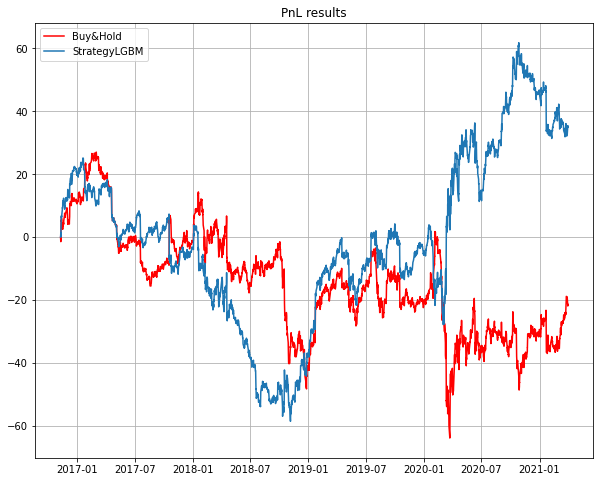

Accuracy: 0.515748031496063
f1: 0.5651346206146315


In [147]:
backtester.plot_pnl(True, 'StrategyLGBM_3780_756.pkl')